<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/CTC_train_eval_Colab_Result_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
import random
import copy

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'


with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]

print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

dataset_size = len(metadata)

(12853, 5)
(12833, 5)


In [0]:
character_length = list()
file_length = list()
division_length = list()
unicode_jamo_list = list()

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = []

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    
unicode_jamo_list.sort()

unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    if not os.path.isfile(mel_path):
#         print("{}".format(mel_path))
        y, sr = librosa.core.load(wav_path)
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
        Sxx = np.maximum(Sxx, eps)

        # plt.figure(figsize=(20,20))
        # plt.imshow(20*np.log10(Sxx), origin='lower')
        # plt.colorbar()
        # plt.show()

        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

    #   log_specgram = 20*np.log10(Sxx)
    #   norm_log_specgram = (log_specgram + db_ref) / db_ref

        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

    #   np.save(specgram_path, norm_log_specgram)
        np.save(mel_path, norm_log_mel_specgram)
    #   np.save(specgram_path, Sxx)

    #     print(norm_log_mel_specgram.shape[1])

    #     if i % 1000 == 0:
    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(20 * np.log10(Sxx), origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()

    #         plt.figure(figsize=(8, 4))
    #         plt.imshow(norm_log_mel_specgram, origin='lower', aspect='auto')
    #         plt.colorbar()
    #         plt.show()    

In [0]:
class ResidualGRU(nn.Module):
    def __init__(self, D_in, bidirectional=True):
        super(ResidualGRU, self).__init__()
        self.gru = nn.GRU(D_in, int(D_in/2), bidirectional=bidirectional, batch_first=True)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        
#         print("Residual Input: {}".format(input_tensor.shape))
        gru_output, _ = self.gru(input_tensor)
        activated = self.relu(gru_output)  
#         print("Residual Output: {}".format(activated.shape))
        output_tensor = torch.add(activated, input_tensor)
        
        return output_tensor

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.H = H
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
            
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        
        output_tensor, _ = self.gru(output_tensor)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        self.H = H
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        output_tensor,_ = self.gru(input_tensor)

        output_tensor = self.fc(output_tensor)
        
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.H = H
        
        self.encoder = Encoder(D_in, H).to(device)
        self.embedding_layer = nn.Embedding(len(jamo_tokens), 256).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)
        self.embedding_optimizer = optim.Adam(self.embedding_layer.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()
        self.embedding_optimizer.zero_grad()

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
#         print(pred_tensor)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        self.embedding_optimizer.step()
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        batch_size = input_tensor.shape[0]

        encoded_tensor = self.encoder(input_tensor)

        pred_tensor = self.decoder(encoded_tensor)
            
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
        self.embedding_layer.eval()
        self.encoder.eval()
        self.decoder.eval()
        
        self.embedding_layer.train()
        self.encoder.train()
        self.decoder.train()
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        input_spectrogram = norm_log_mel_specgram.T
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
        
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            pad_random = np.random.randint(0, 5)
            
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                target = torch.cat((offset, target), 1)
                
            target = target + (torch.rand(target.shape) - 0.5) / 20
        
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [19]:
print(len(mel_path_list))

print(len(ground_truth_list))

split_index = int(0.8 * len(mel_path_list))

print(split_index)

mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_test = mel_path_list[split_index:]
ground_truth_list_test = ground_truth_list[split_index:]

print(len(mel_path_list_test))

12833
12833
10266
10266
2567


In [21]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_test = Batched_Preloader(mel_path_list_test, ground_truth_list_test, 128)
preloader_test.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 128)
preloader_train.initialize_preloader()

In [0]:
def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [27]:
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_2.npy').tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_2.npy').tolist()
except:
    print("Loading Failed")

Loading Failed


Loading Error
09-01 12:13:12
Mean Train Loss: 0.06217890371388369
Mean Evaluation Loss: 0.0599713061671948
-------------------------------------------------------------------------------------------------------
09-01 12:13:31
Mean Train Loss: 0.06065441021870768
Mean Evaluation Loss: 0.058632909833279234
-------------------------------------------------------------------------------------------------------
09-01 12:13:52
Mean Train Loss: 0.05991295149497169
Mean Evaluation Loss: 0.06429867093326551
-------------------------------------------------------------------------------------------------------
09-01 12:14:12
Mean Train Loss: 0.06433618279298262
Mean Evaluation Loss: 0.061073369592715074
-------------------------------------------------------------------------------------------------------
09-01 12:14:32
Mean Train Loss: 0.06147735549630702
Mean Evaluation Loss: 0.05827032884469663
---------------------------------------------------------------------------------------------------

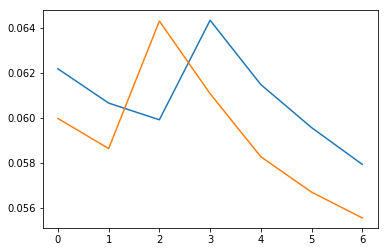

이---------------------------으-으-으---ᅡ--아-고--으--으--으-이--어--아-으--으------으----이- 아---------가--가--아--아-아--아--아-아-아--이--습ᆸ----------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이으으으ᅡ아고으으으이어아으으으이 아가가아아아아아아아이습니다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


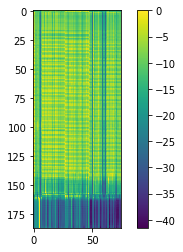

아--------------------ᅳ--사--가--으- 으--으-----이--시--시------사-서---서--이--이--이-으- 아---이-이- 이-이- 이--ᅳ-ᆸ---------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아ᅳ사가으 으으이시시사서서이이이으 아이이 이이 이ᅳᆸ니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


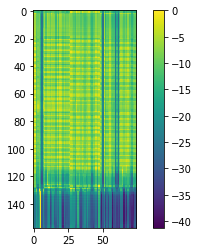

-------------------------------------------------------------------------------------------------------
09-01 12:15:34
Mean Train Loss: 0.0566180973250345
Mean Evaluation Loss: 0.05465025717246872
-------------------------------------------------------------------------------------------------------
09-01 12:15:54
Mean Train Loss: 0.05580780403749041
Mean Evaluation Loss: 0.05426401206725428
-------------------------------------------------------------------------------------------------------
09-01 12:16:14
Mean Train Loss: 0.055249438483000075
Mean Evaluation Loss: 0.0542167810810563
-------------------------------------------------------------------------------------------------------
09-01 12:16:35
Mean Train Loss: 0.05511525392567108
Mean Evaluation Loss: 0.05441447640020837
-------------------------------------------------------------------------------------------------------
09-01 12:16:55
Mean Train Loss: 0.05618022739594374
Mean Evaluation Loss: 0.06217637563660639
-----------

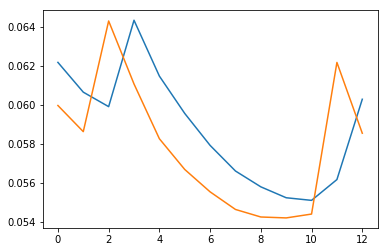

자-------------------는-으-어-아-으-ᄋ--으----아--ᅡ--ᄋ--아-아-아--아--아--어- 으--으--ᄋ-----ᅩ--아--아--으-----아-아-----아---ᆸ---니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
자는으어아으ᄋ으아ᅡᄋ아아아아아어 으으오아아으아아압니다.<eos>
오늘 이렇게 한국어에 관한 초청 강연을 할 수 있게 되어 영광스럽게 생각합니다.<eos>----------


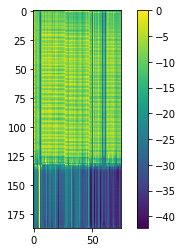

어--------------------안-아--은-으---ᅵ--ᅵ-아--으---이--이------ᅳ------------------아-------아--아--ᅡ-으--이- 으- 아--아-------------이아.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
어안아은으ᅵᅵ아으이이ᅳ아아아ᅡ으이 으 아아이아.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


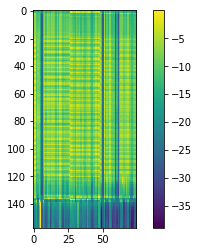

-------------------------------------------------------------------------------------------------------
09-01 12:17:36
Mean Train Loss: 0.059469704311582994
Mean Evaluation Loss: 0.06043154689611575
-------------------------------------------------------------------------------------------------------
09-01 12:17:56
Mean Train Loss: 0.0598328299099532
Mean Evaluation Loss: 0.05643056097469571
-------------------------------------------------------------------------------------------------------
09-01 12:18:16
Mean Train Loss: 0.061228786829232135
Mean Evaluation Loss: 0.07328446640370201
-------------------------------------------------------------------------------------------------------
09-01 12:18:36
Mean Train Loss: 0.0688036880556121
Mean Evaluation Loss: 0.0635136504852119
-------------------------------------------------------------------------------------------------------
09-01 12:18:56
Mean Train Loss: 0.06267479099071502
Mean Evaluation Loss: 0.058262669795399645
----------

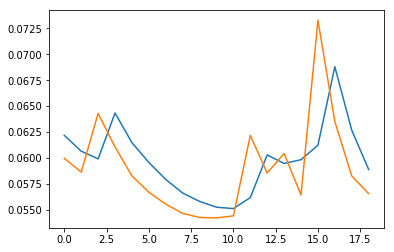

그--------------------아--아--아---이--이---아--아--으--아--아--이----------아--아--으--아---ᄋ---아--아--아--아--아--으--아------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그아아아이이아아으아아이아아으아ᄋ아아아아아으아아요.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


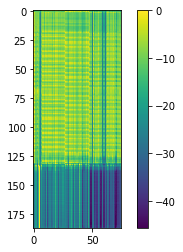

아-------------------느--아--아--아--아--아--아--------아--이--아--아--아--으--아--아--아--아--이--이--아--아--아--아-ᆸ--니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아느아아아아아아아이아아아으아아아아이이아아아압니다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


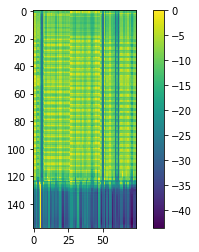

-------------------------------------------------------------------------------------------------------
09-01 12:19:36
Mean Train Loss: 0.058487949095944215
Mean Evaluation Loss: 0.055637056836544706
-------------------------------------------------------------------------------------------------------
09-01 12:19:56
Mean Train Loss: 0.05749797963062771
Mean Evaluation Loss: 0.05693377439060183
-------------------------------------------------------------------------------------------------------
09-01 12:20:17
Mean Train Loss: 0.05808261085320604
Mean Evaluation Loss: 0.06348258158255088
-------------------------------------------------------------------------------------------------------
09-01 12:20:38
Mean Train Loss: 0.059900417301943384
Mean Evaluation Loss: 0.05644312390289731
-------------------------------------------------------------------------------------------------------
09-01 12:20:57
Mean Train Loss: 0.058269034198428174
Mean Evaluation Loss: 0.0616271719413452
-------

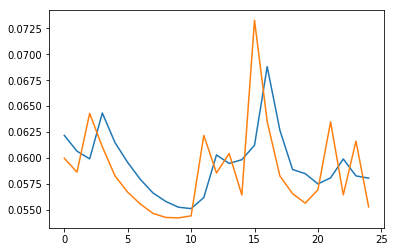

자------------------------아--아--아--으- 아-사- 어--아---오------아--아-어---------ᄀ------ᄋ--아----------아--바-------------ᅡ--ᄇ--------------ᄉ--사--ᄋ----------ᅵ--이-이--이-----니다.<eos><eos><eos><eos>
자아아아으 아사 어아오아아어ᄀᄋ아아바ᅡᄇᄉ사이이이이니다.<eos>
국제연합의 공식 언어는 아랍어, 중국어, 영어, 불어, 러시아어, 스페인어이다.<eos>-----------------


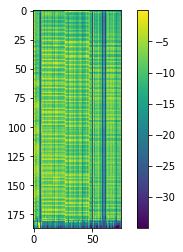

가--------------------ᅳ--으--은 으--으----------사--시-이--이--이- 오- 아--아-이- 이- 아- 아- 아-아--------요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
가ᅳ으은 으으사시이이이 오 아아이 이 아 아 아아요.<eos>
한국의 부모들은 자식들에게 너무 많은 것을 요구하는 것 같아요.<eos>---------------


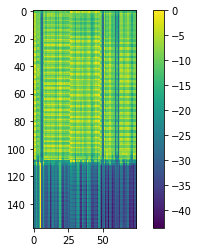

-------------------------------------------------------------------------------------------------------
09-01 12:21:38
Mean Train Loss: 0.05565499183817655
Mean Evaluation Loss: 0.054516619997878074
-------------------------------------------------------------------------------------------------------
09-01 12:21:58
Mean Train Loss: 0.057997389516882346
Mean Evaluation Loss: 0.06426810744126091
-------------------------------------------------------------------------------------------------------
09-01 12:22:18
Mean Train Loss: 0.06005033845084452
Mean Evaluation Loss: 0.061029018694576956
-------------------------------------------------------------------------------------------------------
09-01 12:22:38
Mean Train Loss: 0.058664598584931865
Mean Evaluation Loss: 0.061578358374637
-------------------------------------------------------------------------------------------------------
09-01 12:22:58
Mean Train Loss: 0.05875533145815135
Mean Evaluation Loss: 0.06029750980020476
--------

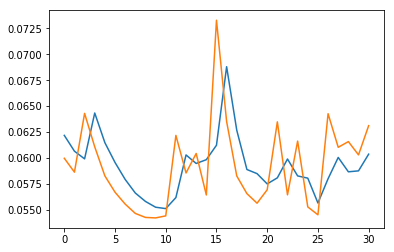

자-----------------아-이-시--이--이-----아-이--으--으--그---ᅳ---아--아--아--아--아---ᅳ--으------아--아--아--으---으--ᄋ--아-ᆻ-------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
자아이시이이아이으으그ᅳ아아아아아ᅳ으아아아으으ᄋ았다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


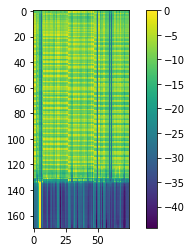

이---------------------------------------------ᄋ--아---ᅳ---아--------------아--아--아--아--아--아-----다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이ᄋ아ᅳ아아아아아아아다.<eos>
내 생각에는 외로움을 달래는 데는 티브이만 한 게 없는 거 같아.<eos>---------------


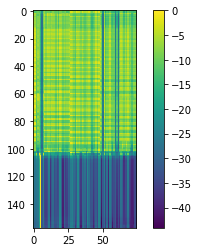

-------------------------------------------------------------------------------------------------------
09-01 12:23:39
Mean Train Loss: 0.05843369098805443
Mean Evaluation Loss: 0.06426329500045387
-------------------------------------------------------------------------------------------------------
09-01 12:23:59
Mean Train Loss: 0.05895761161218496
Mean Evaluation Loss: 0.05935770967667898
-------------------------------------------------------------------------------------------------------
09-01 12:24:19
Mean Train Loss: 0.058408006445207064
Mean Evaluation Loss: 0.05705908407784133
-------------------------------------------------------------------------------------------------------
09-01 12:24:39
Mean Train Loss: 0.05704151904678967
Mean Evaluation Loss: 0.062245921983715535
-------------------------------------------------------------------------------------------------------
09-01 12:24:59
Mean Train Loss: 0.05838826010718755
Mean Evaluation Loss: 0.0627107690870401
---------

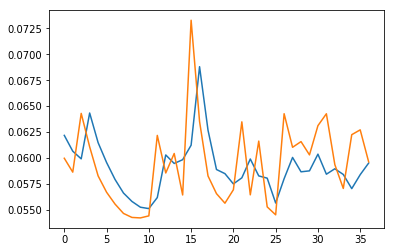

기------------------------이------으---으--으--으---ᅳ---ᅳ--아--아--아--아--아--으---ᅳ--아--이--이-이--으---ᅳ--으--이--이--으--이--이--입-------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
기이으으으으ᅳᅳ아아아아아으ᅳ아이이이으ᅳ으이이으이이입다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


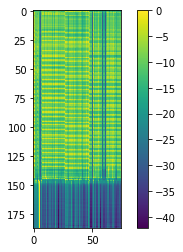

이---------------아--아--아--ᅡ--아-아--이--이--이-아--아--으--으--으--아--아--아--아--아--아--아-ᆻ-----다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이아아아ᅡ아아이이이아아으으으아아아아아아았다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


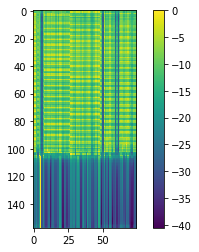

-------------------------------------------------------------------------------------------------------
09-01 12:25:41
Mean Train Loss: 0.058740134215119026
Mean Evaluation Loss: 0.05830024318981824
-------------------------------------------------------------------------------------------------------
09-01 12:26:01
Mean Train Loss: 0.05962690244606524
Mean Evaluation Loss: 0.06208952766400736
-------------------------------------------------------------------------------------------------------
09-01 12:26:21
Mean Train Loss: 0.060200219191267716
Mean Evaluation Loss: 0.059847302389292575
-------------------------------------------------------------------------------------------------------
09-01 12:26:41
Mean Train Loss: 0.059095069197358525
Mean Evaluation Loss: 0.06019422608454004
-------------------------------------------------------------------------------------------------------
09-01 12:27:00
Mean Train Loss: 0.059776705448196854
Mean Evaluation Loss: 0.06071606108652456
-----

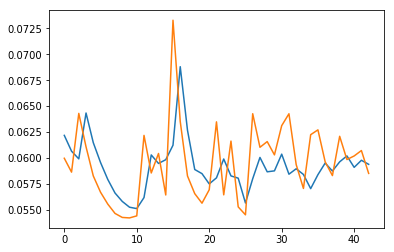

즈---------------으--아--아--아--아--아--아--아--아--이--이--이--아--아--사--아---ᅳ--아--아--아--아--아--이--으--아--아--아--아--아---------요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
즈으아아아아아아아아이이이아아사아ᅳ아아아아아이으아아아아아요.<eos>
제가 그 오페라의 주연을 따냈다는 얘기를 들었을 때 저는 정말 믿기지가 않았어요.<eos>------------


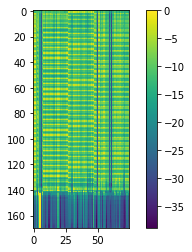

이---------ᅳ--이--이--으--으--이--아--아--아--아--이--아--이--아--아--이--이--이--이--이--이--이--이--있------요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이ᅳ이이으으이아아아아이아이아아이이이이이이이이있요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


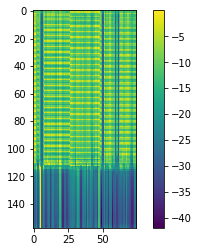

-------------------------------------------------------------------------------------------------------
09-01 12:27:41
Mean Train Loss: 0.0582119964018233
Mean Evaluation Loss: 0.05883703847773456
-------------------------------------------------------------------------------------------------------
09-01 12:28:00
Mean Train Loss: 0.057837980448872506
Mean Evaluation Loss: 0.059158730743874156
-------------------------------------------------------------------------------------------------------
09-01 12:28:20
Mean Train Loss: 0.05778146851239429
Mean Evaluation Loss: 0.058856984445186535
-------------------------------------------------------------------------------------------------------
09-01 12:28:40
Mean Train Loss: 0.05760697504091181
Mean Evaluation Loss: 0.0577948706910511
-------------------------------------------------------------------------------------------------------
09-01 12:29:00
Mean Train Loss: 0.05715666839657185
Mean Evaluation Loss: 0.05745307730675267
---------

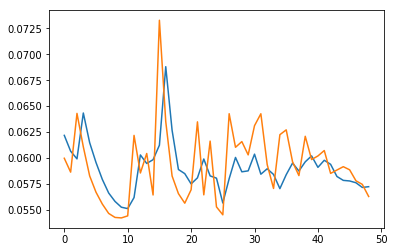

자--------------------아--이--이--이--시--아--이--아--아--이--이--이--아--아---ᅡ--아--이- 이--이---ᅵ---ᅳ- 으--아--사--이--아--이--이--이--이---ᅵ--다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
자아이이이시아이아아이이이아아ᅡ아이 이이ᅵᅳ 으아사이아이이이이ᅵ다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


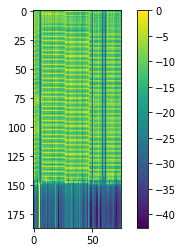

이-------------------ᅵ--으--으--으--이--이--아--아--아--아--아--아--으--으------아--아--으--으--으--아--있------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이ᅵ으으으이이아아아아아아으으아아으으으아있다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


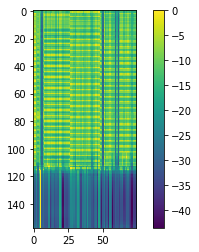

-------------------------------------------------------------------------------------------------------
09-01 12:29:41
Mean Train Loss: 0.05644292189702147
Mean Evaluation Loss: 0.05616595928323361
-------------------------------------------------------------------------------------------------------
09-01 12:30:01
Mean Train Loss: 0.05622367094957868
Mean Evaluation Loss: 0.05575359331834028
-------------------------------------------------------------------------------------------------------
09-01 12:30:21
Mean Train Loss: 0.05609440655339498
Mean Evaluation Loss: 0.05551367383895537
-------------------------------------------------------------------------------------------------------
09-01 12:30:41
Mean Train Loss: 0.056555267213291696
Mean Evaluation Loss: 0.05721844944723205
-------------------------------------------------------------------------------------------------------
09-01 12:31:01
Mean Train Loss: 0.05624988512901159
Mean Evaluation Loss: 0.055753522394676854
--------

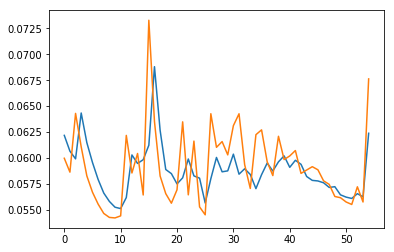

아-------------------------------------------아--ᅡ---- -ᅡ--ᅡ------ᅡ- -ᅡ-안 -ᅡ-아--ᅡ--- 아---------- -- -ᅡ--ᅡ-이-아- 아--ᅡ---ᅡ-사- ᅵ- 아---------------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아아ᅡ ᅡᅡᅡ ᅡ안 ᅡ아ᅡ 아  ᅡᅡ이아 아ᅡᅡ사 ᅵ 아다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


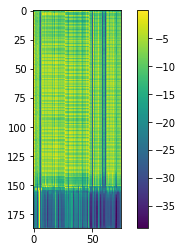

아-ᄂ--------------------------아---- ᄋ--이- -- 아- -- 아 아--ᅡ- 아 아- -- -- 아-아- -- ᄋ- --------------다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아ᄂ아 ᄋ이  아  아 아ᅡ 아 아   아아  ᄋ 다.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


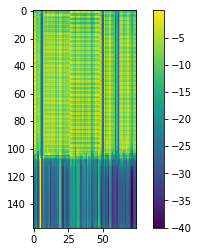

-------------------------------------------------------------------------------------------------------
09-01 12:31:42
Mean Train Loss: 0.06565159406016464
Mean Evaluation Loss: 0.06586005907894672
-------------------------------------------------------------------------------------------------------
09-01 12:32:01
Mean Train Loss: 0.06486022586324514
Mean Evaluation Loss: 0.07513066669485356
-------------------------------------------------------------------------------------------------------
09-01 12:32:21
Mean Train Loss: 0.07194793401379343
Mean Evaluation Loss: 0.07126368533138594
-------------------------------------------------------------------------------------------------------
09-01 12:32:41
Mean Train Loss: 0.0706198014186011
Mean Evaluation Loss: 0.07041048385517291
-------------------------------------------------------------------------------------------------------
09-01 12:33:02
Mean Train Loss: 0.06990116525917518
Mean Evaluation Loss: 0.06950711721893318
-----------

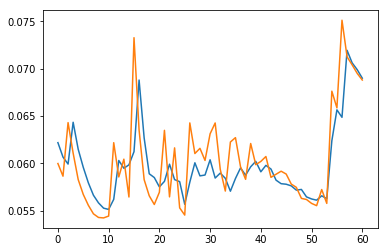

그----------------------ᅡ-ᅡᄉᄉ----  --ᅵ- - -   -ᅡ  -  ------ᅡᅡᅡᅡᄉᄉᄉ -----  ᄉ사-ᅡᅡ  ---- -  -----ᅡᅡᅡᅡᅡᅡᅡ - ᄉ    --ᄉ-------------ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그ᅡᅡᄉ ᅵ   ᅡ  ᅡᄉ  사ᅡ   ᅡ  ᄉ ᄉᆻ다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


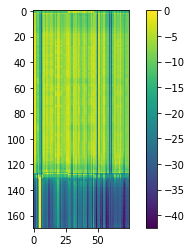

자----------------------ᄉᄉ----------------- ᅵᅵ    ᅵ-ᅵ                 -  ------------------------------------에요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
자ᄉ ᅵ ᅵᅵ  에요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


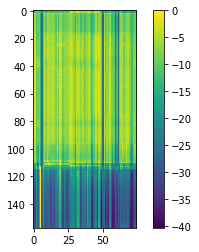

-------------------------------------------------------------------------------------------------------
09-01 12:33:42
Mean Train Loss: 0.0682370454320561
Mean Evaluation Loss: 0.06778014698656532
-------------------------------------------------------------------------------------------------------
09-01 12:34:02
Mean Train Loss: 0.0671866040820263
Mean Evaluation Loss: 0.06632329819713172
-------------------------------------------------------------------------------------------------------
09-01 12:34:22
Mean Train Loss: 0.06616366393378739
Mean Evaluation Loss: 0.06677247323187141
-------------------------------------------------------------------------------------------------------
09-01 12:34:43
Mean Train Loss: 0.06509706410254536
Mean Evaluation Loss: 0.06664139283697194
-------------------------------------------------------------------------------------------------------
09-01 12:35:02
Mean Train Loss: 0.06426392573350419
Mean Evaluation Loss: 0.06640044095998027
------------

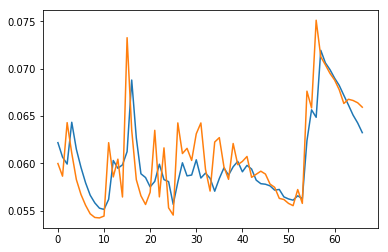

저--------------------------ᅳᆫ ᅡᅡ시ᅵ ᄉ사ᅡ 시---ᅳᅳ-ᄋ-------------ᅡᅡ가사ᅡ ᅡᅡ--ᆫ 가ᅡᅡᆯᄋ 이   ᅳ -ᅳ-가ᅡ그ᄋ아 ---ᅡᅡᄋ---ᅳ -------- ᅡᅩ--ᅵᅳ가ᅡᄉᄉ-------------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저ᅳᆫ ᅡ시 사 시ᅳ아가사 ᅡᆫ 갈ᄋ 이 ᅳ ᅳ가그아 ᅡ으  ᅡᅩᅵᅳ가ᄉ어요.<eos>
처음 이곳에 이사 왔을 때 걸어서 닿는 거리에 식료품 가게가 있다는 게 참 좋았어요.<eos>----------


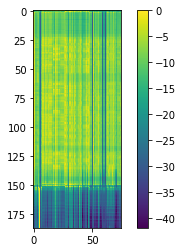

저---------------------- ᄉ시  ᆫᆫ-  ᄉᄉ-          시  - -     -     ------------    ᄉᄉ시 ᅵ  ᅵ ----------------네요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저 시 ᆫ ᄉ 시     시 ᅵ ᅵ 네요.<eos>
저는 음식을 젓가락으로 집어 먹는 것보다 포크로 찍는 게 편해요.<eos>--------------


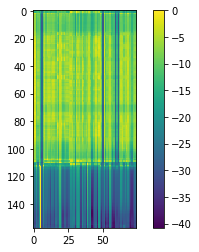

-------------------------------------------------------------------------------------------------------
09-01 12:35:43
Mean Train Loss: 0.062329454837447146
Mean Evaluation Loss: 0.06747083360236773
-------------------------------------------------------------------------------------------------------
09-01 12:36:02
Mean Train Loss: 0.06081639964422082
Mean Evaluation Loss: 0.06672847449604728
-------------------------------------------------------------------------------------------------------
09-01 12:36:22
Mean Train Loss: 0.05954822628237529
Mean Evaluation Loss: 0.06616285730082316
-------------------------------------------------------------------------------------------------------
09-01 12:36:42
Mean Train Loss: 0.05826231964260454
Mean Evaluation Loss: 0.06614610115261496
-------------------------------------------------------------------------------------------------------
09-01 12:37:02
Mean Train Loss: 0.05717241714501411
Mean Evaluation Loss: 0.06587140163708877
---------

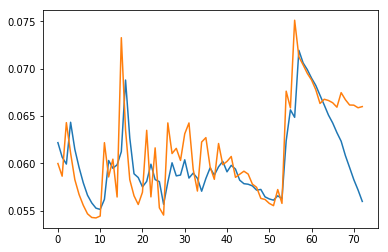

아-------------------------ᄉ사-ᄉ사-슬 아- 어 더-어--어-----  안이ᅵ아 아-시  자-으------- ᅡᅡ르 장한 가- ᅥᅩ  아  이-시-------------------ᅵ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
아사사슬 아 어 더어어 안이아 아시 자으 ᅡ르 장한 가 ᅥᅩ 아 이시ᅵ다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


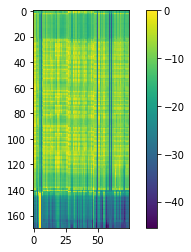

우-------------------ᄋ-ᆫ ᄋ----------- ᄋ-  -이- - ᄋ- 진 -ᆫ-------  ᄋ-  - ᄋᆫ --- ᅵ- ᄋ- ᄋ--ᄀ---- ----ᅵ----------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우ᄋᆫ ᄋ ᄋ 이  ᄋ 진 ᆫ ᄋ  ᄋᆫ  ᅵ ᄋ ᄋᄀ ᅵ니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


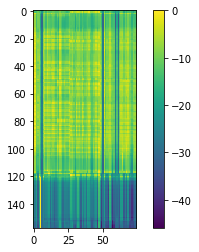

-------------------------------------------------------------------------------------------------------
09-01 12:37:42
Mean Train Loss: 0.05527532551401827
Mean Evaluation Loss: 0.06573818795439496
-------------------------------------------------------------------------------------------------------
09-01 12:38:02
Mean Train Loss: 0.054681011624528625
Mean Evaluation Loss: 0.06420415190820096
-------------------------------------------------------------------------------------------------------
09-01 12:38:23
Mean Train Loss: 0.05399089614780867
Mean Evaluation Loss: 0.06486521940574996
-------------------------------------------------------------------------------------------------------
09-01 12:38:42
Mean Train Loss: 0.05334248208700691
Mean Evaluation Loss: 0.06795109652546552
-------------------------------------------------------------------------------------------------------
09-01 12:39:02
Mean Train Loss: 0.0528322976533662
Mean Evaluation Loss: 0.06691087880280185
----------

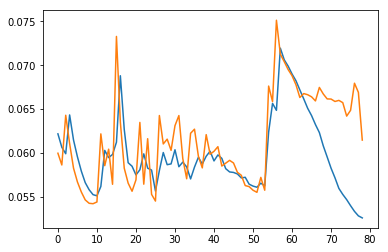

이--------------------------이-은 ᅳᆫ질 사--으------   ᅩᅩ 자ᅡᅡᅡ-성 ᅵ-진 자-든느  간으-으-여-------  하 잰시-언 ᅳᆫ 가ᄋ  ᅡᅡ 거 가----------------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이이은 ᅳᆫ질 사으 ᅩ 자성 ᅵ진 자든느 간으으여 하 잰시언 ᅳᆫ 가ᄋ ᅡ 거 가니다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


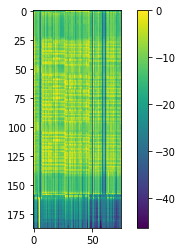

우-----------------------ᅳᆫ 성 ᄆᆫ-ᄋᆫ-   ᄋᆫ ᄋᆫ  주-징 ---ᄉᄉ--ᄋ----------  -ᄉ-우  --ᄋ--ᄋ--ᄋᆫ  ᅩᆫ-이-오-이-시--ᄋ-------------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우ᅳᆫ 성 ᄆᆫᄋᆫ ᄋᆫ ᄋᆫ 주징 ᄉᄋ ᄉ우 ᄋᄋᄋᆫ ᅩᆫ이오이시ᄋ니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


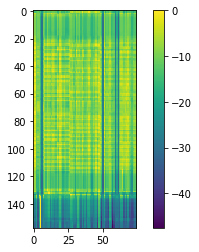

-------------------------------------------------------------------------------------------------------
09-01 12:39:42
Mean Train Loss: 0.05212953552035714
Mean Evaluation Loss: 0.06333330424777132
-------------------------------------------------------------------------------------------------------
09-01 12:40:02
Mean Train Loss: 0.05147988015987172
Mean Evaluation Loss: 0.06289641511395665
-------------------------------------------------------------------------------------------------------
09-01 12:40:22
Mean Train Loss: 0.05102898219763389
Mean Evaluation Loss: 0.06316367295516825
-------------------------------------------------------------------------------------------------------
09-01 12:40:42
Mean Train Loss: 0.0506236199483297
Mean Evaluation Loss: 0.06129341357667626
-------------------------------------------------------------------------------------------------------
09-01 12:41:01
Mean Train Loss: 0.0505685518633264
Mean Evaluation Loss: 0.061032254635781685
-----------

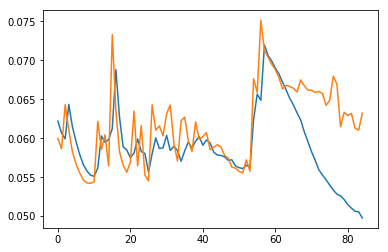

그-------------------구른 ᄀᆯ를 ᅡᅡ하-ᄌ젠-ᆫ 거ᅩ-은다ᅡ아ᅡ-시-아---------  자를 에이ᅵ ᅡᅡ-ᅩ로---  거 그ᄅᄅᆯ 서-아-자-ᄋ------------------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그구른 ᄀᆯ를 ᅡ하젠ᆫ 거ᅩ은다아시아 자를 에이 ᅡᅩ로 거 그ᄅᆯ 서아자ᄋ어요.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


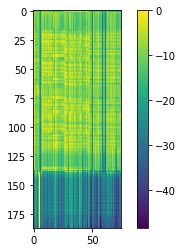

이----------------시 진  ᆫ 이 은문ᄋᄋᆫ---  ᅮᆫ안 ᅳᅩᆫ오 군은오  모- ᄋᆫ-오------  정엉어-ᄋᄋ--------------------ᆻ어.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이시 진 ᆫ 이 은문ᄋᆫ ᅮᆫ안 ᅳᅩᆫ오 군은오 모 ᄋᆫ오 정엉어ᄋᆻ어.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


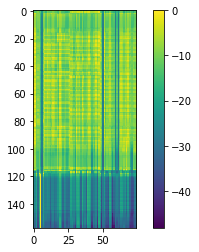

-------------------------------------------------------------------------------------------------------
09-01 12:41:42
Mean Train Loss: 0.04940984707799181
Mean Evaluation Loss: 0.060416849079221444
-------------------------------------------------------------------------------------------------------
09-01 12:42:02
Mean Train Loss: 0.04903029007172091
Mean Evaluation Loss: 0.06234913425440021
-------------------------------------------------------------------------------------------------------
09-01 12:42:22
Mean Train Loss: 0.04888667116419166
Mean Evaluation Loss: 0.060691064004955206
-------------------------------------------------------------------------------------------------------
09-01 12:42:41
Mean Train Loss: 0.04827462137411744
Mean Evaluation Loss: 0.05979734178941929
-------------------------------------------------------------------------------------------------------
09-01 12:43:01
Mean Train Loss: 0.047726459606169135
Mean Evaluation Loss: 0.06107547337241205
-------

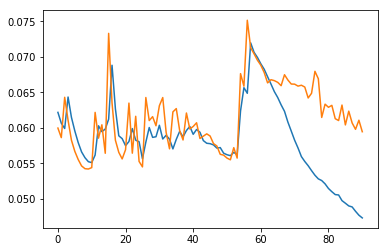

으--------는 마  서ᄉᄉᄋᆯ으ᅳᆫ 자ᅡᆫᆫ 지  수- 소-다ᅡ-ᅡᅡ-느----------  자아-이 아-으-으-----  다른 지 어 오ᄀ어 기ᄉ시가-은거--------------ᅵ아.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
으는 마 서ᄉᄋᆯ은 잔 지 수 소다ᅡ느 자아이 아으으 다른 지 어 오ᄀ어 기시가은거ᅵ아.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


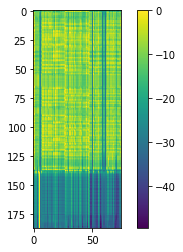

이------------------------ᄋᆫᆼᄋᆫ 문이  ᅵᆫᄋ---ᅥ--  - 인은 은 ᄀᆫ-앙---------  ᄀᆫ-으-잉잉웅ᄋ이-ᄋ------------------ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이ᄋᆫᆼᄋᆫ 문이 ᅵᆫ어  인은 은 ᄀᆫ앙 ᄀᆫ으잉잉웅이ᄋᆻ다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


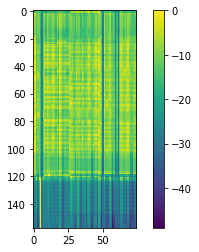

-------------------------------------------------------------------------------------------------------
09-01 12:43:42
Mean Train Loss: 0.04677190081237786
Mean Evaluation Loss: 0.05989264502742363
-------------------------------------------------------------------------------------------------------
09-01 12:44:02
Mean Train Loss: 0.04686380015241071
Mean Evaluation Loss: 0.0614391631638716
-------------------------------------------------------------------------------------------------------
09-01 12:44:22
Mean Train Loss: 0.04633352414003871
Mean Evaluation Loss: 0.05860864370373359
-------------------------------------------------------------------------------------------------------
09-01 12:44:42
Mean Train Loss: 0.04585029727339675
Mean Evaluation Loss: 0.05953340883132299
-------------------------------------------------------------------------------------------------------
09-01 12:45:02
Mean Train Loss: 0.04570898733402834
Mean Evaluation Loss: 0.060503950818071466
----------

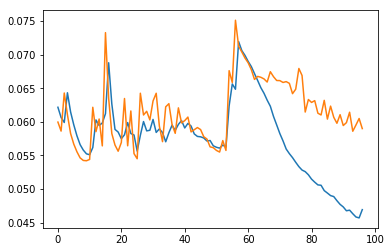

그--------------------로 실안이 단지--대-여-ᆫ----  구ᄅᆯ라 안 공가ᅡ ᄒᆫ 그ᄅᄅ 자ᅡ드ᄅᄋ 사ᅡ이 에- 지-은-   대-산들 가-ᄋ----------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그로 실안이 단지대연 구ᄅᆯ라 안 공가 ᄒᆫ 그ᄅ 자드ᄅᄋ 사이 에 지은 대산들 가ᄋ니다.<eos>
근로 시간이 단축되면 근로 환경과 근로자들의 삶의 질이 개선될 것입니다.<eos>------------------


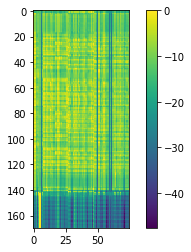

조--------------------난ᆫᄆᆫᆫ문이 문이 잔는  이-인ᄋᆫ 난는ᄂ--------------  마-머--조--  모-언이 인이--  --------------------ᆫ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
조난ᄆᆫ문이 문이 잔는 이인ᄋᆫ 난는ᄂ 마머조 모언이 인이 ᆫ요.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


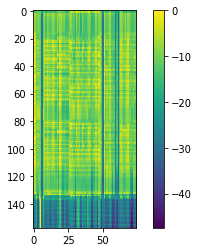

-------------------------------------------------------------------------------------------------------
09-01 12:45:42
Mean Train Loss: 0.04544554317341672
Mean Evaluation Loss: 0.059528970426192984
-------------------------------------------------------------------------------------------------------
09-01 12:46:02
Mean Train Loss: 0.04469206196127165
Mean Evaluation Loss: 0.06100806846248999
-------------------------------------------------------------------------------------------------------
09-01 12:46:22
Mean Train Loss: 0.044524204248619074
Mean Evaluation Loss: 0.05982731983357162
-------------------------------------------------------------------------------------------------------
09-01 12:46:42
Mean Train Loss: 0.04418795769582334
Mean Evaluation Loss: 0.061196232005994625
-------------------------------------------------------------------------------------------------------
09-01 12:47:02
Mean Train Loss: 0.043729100133035895
Mean Evaluation Loss: 0.05937907686399817
------

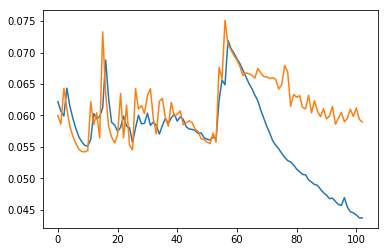

스-----------------------ᅳᅳ른 산온 고 사-엘르-아------  오-당지ᄋᄋᆯ 거-다ᅡ-수-라-------  ᄌᄉ세 ᅵᅵᄌᄌᆼ은 단ᆯ달는-ᅡᅡ 소ᄅ오 다-다-해-------------------ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
스ᅳ른 산온 고 사엘르아 오당지ᄋᆯ 거다수라 ᄌ세 ᅵᄌᆼ은 단ᆯ달는ᅡ 소ᄅ오 다다했다.<eos>
최근의 설문 조사 결과 응답자의 과반수가 새 규정에 반대하는 것으로 나타났다.<eos>-----------------


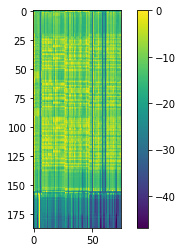

여---------------------믄 웅ᄂᆫᆫ만ᄂᄂᆫᆫ인ᄋᄋᆫ--은  엉만ᆫ인-으--ᆫ--  성우-ᄋᆫ 망우-항ᄋᄋ--ᄋ-----------ᅵᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
여믄 웅ᄂᆫ만ᄂᆫ인ᄋᆫ은 엉만인은 성우ᄋᆫ 망우항ᄋ있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


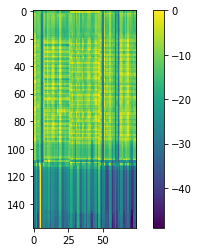

-------------------------------------------------------------------------------------------------------
09-01 12:47:42
Mean Train Loss: 0.043655680231246954
Mean Evaluation Loss: 0.06039089899114323
-------------------------------------------------------------------------------------------------------
09-01 12:48:02
Mean Train Loss: 0.043755515347413905
Mean Evaluation Loss: 0.057766034700423304
-------------------------------------------------------------------------------------------------------
09-01 12:48:22
Mean Train Loss: 0.04261921850044346
Mean Evaluation Loss: 0.05710820314194084
-------------------------------------------------------------------------------------------------------
09-01 12:48:42
Mean Train Loss: 0.04250605790056964
Mean Evaluation Loss: 0.05894793912601065
-------------------------------------------------------------------------------------------------------
09-01 12:49:02
Mean Train Loss: 0.042618255431162065
Mean Evaluation Loss: 0.05670475225629997
------

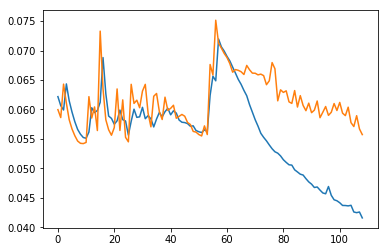

우--------------하-는 자ᄉᄉᆼ는 지-닌이 디ᅵ-오-에----  -녕에ᄋ어 구-를 조-ᄀ가-는ᄃᄃᆫ는ᆫ-   ᅡᅡ-모 갈ᄉ시이 없어ᅥᆻᄋ-------------ᆻᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우하는 자ᄉᆼ는 지닌이 디오에 녕에어 구를 조가는ᄃᆫ는 ᅡ모 갈시이 없었ᄋᆻ다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


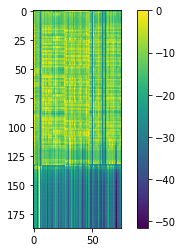

이---------------짐인는ᆫ----  웅징먼-ᄋᆫ 서-징인  머--ᄀ이-마--  우-ᄂᄋᆼᆼ한장인깅은은 핞--------------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이짐인는 웅징먼ᄋᆫ 서징인 머ᄀ이마 우ᄂᄋᆼ한장인깅은은 핞아요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


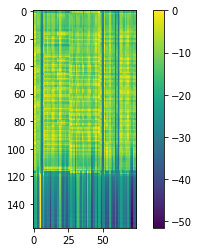

-------------------------------------------------------------------------------------------------------
09-01 12:49:42
Mean Train Loss: 0.041215723423313956
Mean Evaluation Loss: 0.060385497586943705
-------------------------------------------------------------------------------------------------------
09-01 12:50:02
Mean Train Loss: 0.04209166227995541
Mean Evaluation Loss: 0.05558733444122069
-------------------------------------------------------------------------------------------------------
09-01 12:50:22
Mean Train Loss: 0.042645113003295286
Mean Evaluation Loss: 0.055333755972538076
-------------------------------------------------------------------------------------------------------
09-01 12:50:42
Mean Train Loss: 0.04093016631369855
Mean Evaluation Loss: 0.056098601840526854
-------------------------------------------------------------------------------------------------------
09-01 12:51:03
Mean Train Loss: 0.04110998428293918
Mean Evaluation Loss: 0.057064673751393166
----

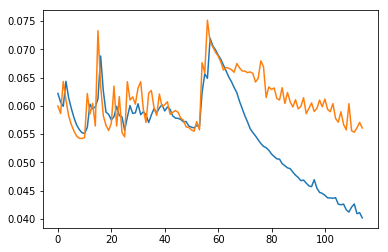

어---------------는 가어  거-지 달라 는는-네-에--------  나-지이 거-지-갈라ᅡ 골-드-으-아--   ᅥᅥ노-하-게 거-어-가----------------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
어는 가어 거지 달라 는는네에 나지이 거지갈라 골드으아 ᅥ노하게 거어가어요.<eos>
혼날까 봐 거짓말을 했는데, 나중에 거짓말을 한 것 때문에 엄마한테 더 혼났어요.<eos>---------


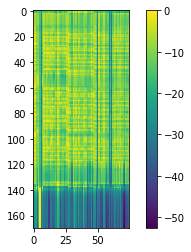

오-------------------인 강ᆼ이-잉은  앤궁ᆼᄋᄂᆫ  ᄉᆫ-궁-이-으----  인영은 싱잉-잉-우--ᄒ--우-----------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
오인 강이잉은 앤궁ᄋᄂᆫ ᄉᆫ궁이으 인영은 싱잉잉우ᄒ우니다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


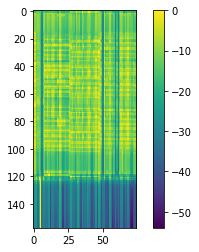

-------------------------------------------------------------------------------------------------------
09-01 12:51:43
Mean Train Loss: 0.04055990702707124
Mean Evaluation Loss: 0.06293144834602418
-------------------------------------------------------------------------------------------------------
09-01 12:52:03
Mean Train Loss: 0.04181002740613469
Mean Evaluation Loss: 0.059358974307684984
-------------------------------------------------------------------------------------------------------
09-01 12:52:23
Mean Train Loss: 0.03996612908487604
Mean Evaluation Loss: 0.06418497554058175
-------------------------------------------------------------------------------------------------------
09-01 12:52:43
Mean Train Loss: 0.03958026070845384
Mean Evaluation Loss: 0.058785200994544484
-------------------------------------------------------------------------------------------------------
09-01 12:53:03
Mean Train Loss: 0.039321659950429244
Mean Evaluation Loss: 0.059933051442163814
------

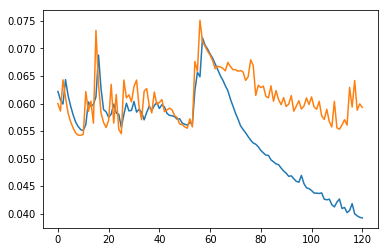

하-------------------국이  고도ᅩ하ᅥ 샌 드 지-에ᄂ는------  이-시 진일를리ᅵ이ᄋᄋᆫ 강군을 간은데  고한 마ᅡ---------------------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
하국이 고도하ᅥ 샌 드 지에는 이시 진일를리이ᄋᆫ 강군을 간은데 고한 마아요.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


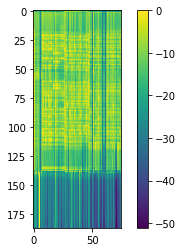

저------------------ᄋ-ᆫ 이 군 이 이 즌 웅 잉 웅 이--닌는-----  숭ᆼᄌ-ᅡᆫ-녕은  성은 심  우--뭉흐--------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저ᄋᆫ 이 군 이 이 즌 웅 잉 웅 이닌는 숭잔녕은 성은 심 우뭉흐니다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


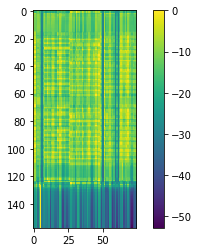

-------------------------------------------------------------------------------------------------------
09-01 12:53:43
Mean Train Loss: 0.03931507042863284
Mean Evaluation Loss: 0.06351565031147507
-------------------------------------------------------------------------------------------------------
09-01 12:54:03
Mean Train Loss: 0.03866679832209113
Mean Evaluation Loss: 0.06255732719024334
-------------------------------------------------------------------------------------------------------
09-01 12:54:23
Mean Train Loss: 0.03817221736144262
Mean Evaluation Loss: 0.06284463107273046
-------------------------------------------------------------------------------------------------------
09-01 12:54:43
Mean Train Loss: 0.03802308927543482
Mean Evaluation Loss: 0.05937933501594948
-------------------------------------------------------------------------------------------------------
09-01 12:55:03
Mean Train Loss: 0.038824211434081914
Mean Evaluation Loss: 0.052341892363510334
--------

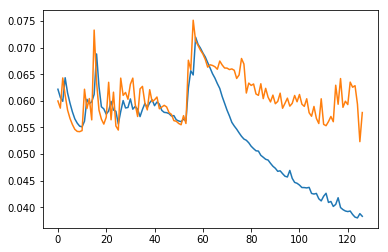

지-------------ᄉ숨곰이  ᅳ 숭 ᅳᄅᄅᄋ오-여--서-----  고-믈은 저-산 고-간 ᅵ 보르ᅩ ᅳᆯ라ᅡᅳᆫᄉ사시ᅵ를 개 다-라---ᆻᆻᆻ--------------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
지숨곰이 ᅳ 숭 ᅳᄅ오여서 고믈은 저산 고간 ᅵ 보르ᅩ ᅳᆯ라ᅳᆫ사시를 개 다랐어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


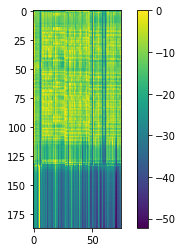

으------------------ᆼ난 뭉우- ᅵ 운이 상는  이-이-ᄒᆫ 항는-애------------  안읏운ᆫᅳᆫ 무-언인는이ᅵ-ᄋᆫ 아---------------------아.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
응난 뭉우 ᅵ 운이 상는 이이ᄒᆫ 항는애 안읏운ᅳᆫ 무언인는이ᄋᆫ 아아.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


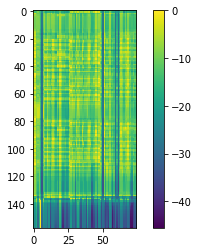

-------------------------------------------------------------------------------------------------------
09-01 12:55:43
Mean Train Loss: 0.037512896055034356
Mean Evaluation Loss: 0.0579069581365936
-------------------------------------------------------------------------------------------------------
09-01 12:56:03
Mean Train Loss: 0.03976783337025145
Mean Evaluation Loss: 0.053211645375414264
-------------------------------------------------------------------------------------------------------
09-01 12:56:23
Mean Train Loss: 0.038463214394834314
Mean Evaluation Loss: 0.05510793076978325
-------------------------------------------------------------------------------------------------------
09-01 12:56:43
Mean Train Loss: 0.03800416556751951
Mean Evaluation Loss: 0.05605726683394886
-------------------------------------------------------------------------------------------------------
09-01 12:57:03
Mean Train Loss: 0.03694359586903434
Mean Evaluation Loss: 0.05448894738874092
--------

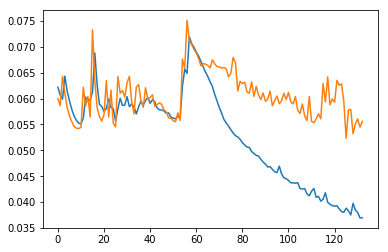

다---------------ᆷ무-이 마-녕ᆼ 한-텅은 사- 군-더-우-오-------- 그ᅳ른 차ᄉ시가ᅡ으 ᄉ사-이ᅵ 다-고-오  마 ᅡᆫ-ᅥᅥ-어----------------ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
담무이 마녕 한텅은 사 군더우오 그른 차시가으 사이 다고오 마 ᅡᆫᅥ었다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


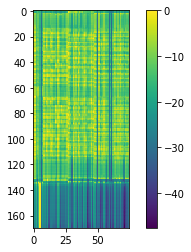

이-----------------만은ᄂ는ᆫ----- 허 싱으ᅳᆫ 숨 한-한는ᆫ--  ᅡᅡ 묵이ᄋ이는 중지ᄋ이-이 이ᅵ-어--ᅵᆻᆻ-----------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이만은는 허 싱은 숨 한한는 ᅡ 묵이이는 중지이이 이어ᅵᆻ어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


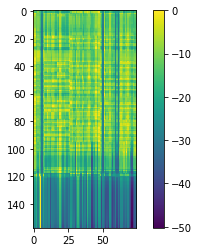

-------------------------------------------------------------------------------------------------------
09-01 12:57:43
Mean Train Loss: 0.036896577087621084
Mean Evaluation Loss: 0.05748179772319737
-------------------------------------------------------------------------------------------------------
09-01 12:58:03
Mean Train Loss: 0.03666384990685182
Mean Evaluation Loss: 0.05425573809885374
-------------------------------------------------------------------------------------------------------
09-01 12:58:23
Mean Train Loss: 0.036474196660111285
Mean Evaluation Loss: 0.055644750847577557
-------------------------------------------------------------------------------------------------------
09-01 12:58:43
Mean Train Loss: 0.03622904232563058
Mean Evaluation Loss: 0.06197168778558917
-------------------------------------------------------------------------------------------------------
09-01 12:59:02
Mean Train Loss: 0.035633819097157945
Mean Evaluation Loss: 0.05400671096871588
------

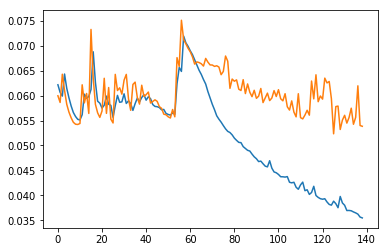

우-----------------리-이-ᆫ 청 고-이  부ᅵᅵᅵ-면에--- 해-사-를 설일 다-기-에----- 아ᅡᄋ은 ᅳᆯ곡긴드ᄅᄋᆯ 기-어이 핬스----ᆸ-----니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우리인 청 고이 부ᅵ면에 해사를 설일 다기에 아은 ᅳᆯ곡긴드ᄅᄋᆯ 기어이 핬습니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


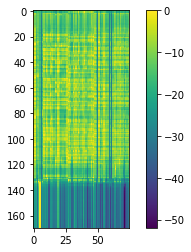

우---------------------은 장-망는 ᄂᄋ-우은 줌중있 있ᆻ으--서-----  싱은 징ᄋᆫ 으-하 고-우-우  있핬-흐---------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우은 장망는 ᄂᄋ우은 줌중있 있으서 싱은 징ᄋᆫ 으하 고우우 있핬흐니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


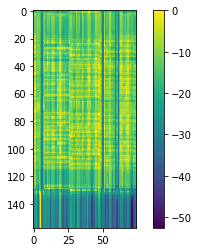

-------------------------------------------------------------------------------------------------------
09-01 12:59:43
Mean Train Loss: 0.036254593502217394
Mean Evaluation Loss: 0.0524778875889632
-------------------------------------------------------------------------------------------------------
09-01 13:00:03
Mean Train Loss: 0.03484533871930175
Mean Evaluation Loss: 0.05448486992483124
-------------------------------------------------------------------------------------------------------
09-01 13:00:23
Mean Train Loss: 0.03561374139693865
Mean Evaluation Loss: 0.05321129311894265
-------------------------------------------------------------------------------------------------------
09-01 13:00:43
Mean Train Loss: 0.03534094384989684
Mean Evaluation Loss: 0.05885890821520863
-------------------------------------------------------------------------------------------------------
09-01 13:01:03
Mean Train Loss: 0.03501515321584901
Mean Evaluation Loss: 0.051247296414924204
---------

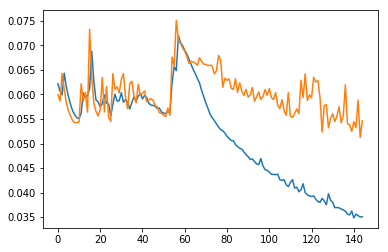

지-------------------그 고 지ᄋ에 가-여 ᄐ태경ᄀᄒᆫᄌᄌᆼᆫᅳᆯ 항무 알르  지-ᄋ--서-----  고-센 드ᅡᄂᄂᆫ  여-잘드-에   애--고  이-ᆻᆻ----------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
지그 고 지에 가여 태경ᄀᄒᆫᄌᆼᆫᅳᆯ 항무 알르 지ᄋ서 고센 드ᅡᄂᆫ 여잘드에 애고 있어요.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


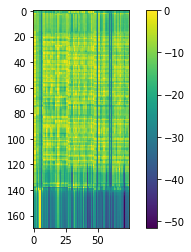

우---------------- 춤움ᆷ은 이-니 무-에---  ᅢ 항으ᅳᆷ문 구-웅ᅳ  고--항-요-고--   성웅ᄒᄒᆻᆻᆻᅳ----ᆻᆻ----------ᆻ어.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우 춤움은 이니 무에 ᅢ 항음문 구웅ᅳ 고항요고 성웅ᄒᆻᅳᆻᆻ어.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


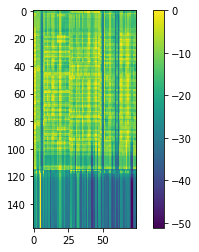

-------------------------------------------------------------------------------------------------------
09-01 13:01:43
Mean Train Loss: 0.03583589701200369
Mean Evaluation Loss: 0.05297249487042617
-------------------------------------------------------------------------------------------------------
09-01 13:02:03
Mean Train Loss: 0.036111058999624
Mean Evaluation Loss: 0.052168812937383416
-------------------------------------------------------------------------------------------------------
09-01 13:02:23
Mean Train Loss: 0.03500792898074675
Mean Evaluation Loss: 0.05119031425122588
-------------------------------------------------------------------------------------------------------
09-01 13:02:43
Mean Train Loss: 0.03456358566016343
Mean Evaluation Loss: 0.05358694655159475
-------------------------------------------------------------------------------------------------------
09-01 13:03:03
Mean Train Loss: 0.034686087276091356
Mean Evaluation Loss: 0.05433817492480821
----------

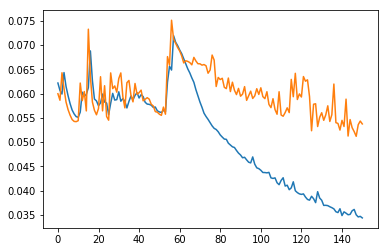

저-----------는 기-가 ᄋ어-도-운-게----- 가-앤사ᅡ하ᅡ이ᅵ 이-ᅵᅵᆯᅳ---  아-지 자ᅡᅡᆯ 드ᄅᆯ직-갈ᄂᄂᆫ 말을-  아ᅡ니ᅵ 들 가어-ᆻᆻ--ᄋ어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 기가 어도운게 가앤사하이 이ᅵᆯᅳ 아지 잘 드ᄅᆯ직갈ᄂᆫ 말을 아니 들 가었어요.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


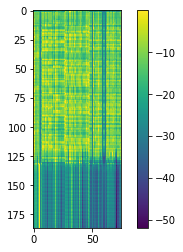

으-----------------승만 ᄆᆼᆼ우 시-움있상난  이-이-했 ᅡᅡ-ᅳ--이------------  마문-숨ᅳᅳᆫ 무-은 ᅵ 닝인니  아-------ᆭ아.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
으승만 ᄆᆼ우 시움있상난 이이했 ᅡᅳ이 마문숨ᅳᆫ 무은 ᅵ 닝인니 않아.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


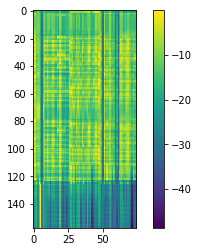

-------------------------------------------------------------------------------------------------------
09-01 13:03:43
Mean Train Loss: 0.03396527022045348
Mean Evaluation Loss: 0.05170647965727159
-------------------------------------------------------------------------------------------------------
09-01 13:04:02
Mean Train Loss: 0.03920626518378161
Mean Evaluation Loss: 0.05252225773616755
-------------------------------------------------------------------------------------------------------
09-01 13:04:22
Mean Train Loss: 0.03478466208240688
Mean Evaluation Loss: 0.04931106016060472
-------------------------------------------------------------------------------------------------------
09-01 13:04:42
Mean Train Loss: 0.034168677815256454
Mean Evaluation Loss: 0.04987575312170524
-------------------------------------------------------------------------------------------------------
09-01 13:05:02
Mean Train Loss: 0.03364358836619108
Mean Evaluation Loss: 0.05122564878648863
---------

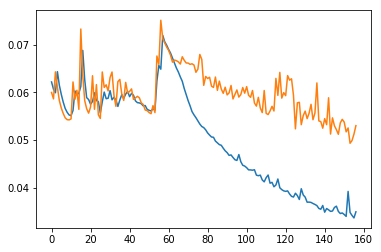

그--------------나-는 자지ᅵ앤진는을 니-령ᄋᄋ-----  며-ᄋ이-ᄋ  둘를 수-가ᅡᅡ늘 대ᄂ는-  나-무-ᄋ ᄋᄋ 실이 없ᄋ어-----ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그나는 자지앤진는을 니령ᄋ 며이ᄋ 둘를 수가늘 대는 나무ᄋ ᄋ 실이 없었다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


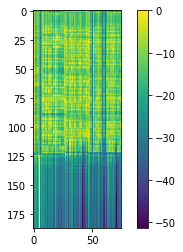

여-------------------은 웅은 항능이  이-구-이  간만ᆫ이- 으----  숭웅은 망뭉항고 이----ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
여은 웅은 항능이 이구이 간만이 으 숭웅은 망뭉항고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


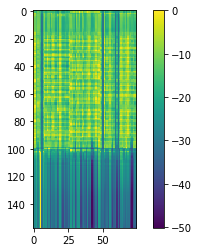

-------------------------------------------------------------------------------------------------------
09-01 13:05:43
Mean Train Loss: 0.0336625854958764
Mean Evaluation Loss: 0.04938318058995616
-------------------------------------------------------------------------------------------------------
09-01 13:06:03
Mean Train Loss: 0.03363382642122476
Mean Evaluation Loss: 0.050393639784537425
-------------------------------------------------------------------------------------------------------
09-01 13:06:23
Mean Train Loss: 0.03331424846760839
Mean Evaluation Loss: 0.051145388298161724
-------------------------------------------------------------------------------------------------------
09-01 13:06:42
Mean Train Loss: 0.03261349476344307
Mean Evaluation Loss: 0.049396748815446395
-------------------------------------------------------------------------------------------------------
09-01 13:07:02
Mean Train Loss: 0.03277878046779096
Mean Evaluation Loss: 0.048466277708611546
-------

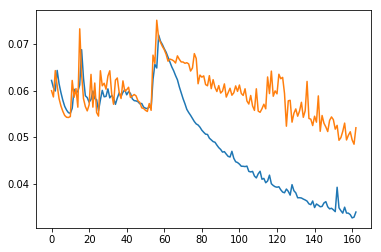

여-----------------볼른 이-고  셌서--ᅥ---   ᅮ-상-이-------   때--가-ᅡ---   ᄑᄅᆯ-레- 글ᆫ----- 가-항한 송일 곤ᄐᄃᆯ를 ᄃ도시ᅵ 징 ᄉ싰스-ᆸᆸ니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
여볼른 이고 셌서ᅥ ᅮ상이 때가ᅡ ᄑᄅᆯ레 글ᆫ 가항한 송일 곤ᄐᄃᆯ를 도시 징 싰습니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


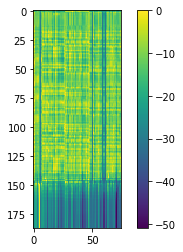

우-------------------니  항잉ᄋ인는  개-궁-은 상 군느--이----  이-웅ᆫ  수ᄉ시ᅵᆼ흥ᆼ 구 드-이----ᆸ니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우니 항잉인는 개궁은 상 군느이 이웅ᆫ 수싱흥 구 드입니다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


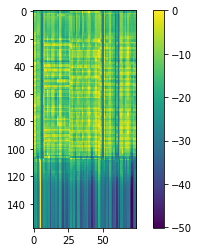

-------------------------------------------------------------------------------------------------------
09-01 13:07:42
Mean Train Loss: 0.03366536626503617
Mean Evaluation Loss: 0.05097177977934162
-------------------------------------------------------------------------------------------------------
09-01 13:08:02
Mean Train Loss: 0.032861221198035175
Mean Evaluation Loss: 0.048360450987983375
-------------------------------------------------------------------------------------------------------
09-01 13:08:22
Mean Train Loss: 0.03264553626089859
Mean Evaluation Loss: 0.04881283735225083
-------------------------------------------------------------------------------------------------------
09-01 13:08:42
Mean Train Loss: 0.03212367296945314
Mean Evaluation Loss: 0.05094641178605083
-------------------------------------------------------------------------------------------------------
09-01 13:09:03
Mean Train Loss: 0.03186812942943111
Mean Evaluation Loss: 0.051521162565139826
-------

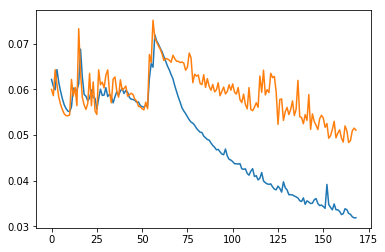

마---------------ᆫ는 여ᅧ-오----  출를 소-수-에-서ᅥ-----  개-경ᆼᅵᅵ 년 지이 공으  지-곰은----   구--성에   시엄 주-으-하-이-ᄉ-서-----라.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
만는 여오 출를 소수에서 개경ᅵ 년 지이 공으 지곰은 구성에 시엄 주으하이ᄉ서라.<eos>
많은 경우 추리 소설에서 배경이나 주인공의 직업은 구성에 있어 중요한 요소다.<eos>---------------


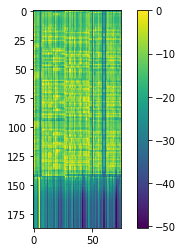

요---------------ᆼ믄 웅은 항능ᄋ이 잉구-으  겅한 인-이----  수-웅은 만므-하-고 이----ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
용믄 웅은 항능이 잉구으 겅한 인이 수웅은 만므하고 있다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


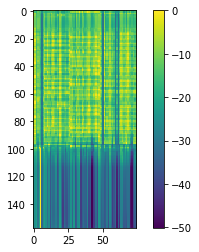

-------------------------------------------------------------------------------------------------------
09-01 13:09:43
Mean Train Loss: 0.03229658096935465
Mean Evaluation Loss: 0.05159885263632214
-------------------------------------------------------------------------------------------------------
09-01 13:10:03
Mean Train Loss: 0.03307453829607242
Mean Evaluation Loss: 0.05143424835652288
-------------------------------------------------------------------------------------------------------
09-01 13:10:22
Mean Train Loss: 0.03285319857676301
Mean Evaluation Loss: 0.049119709078414245
-------------------------------------------------------------------------------------------------------
09-01 13:10:43
Mean Train Loss: 0.032473285568191956
Mean Evaluation Loss: 0.04657226285077614
-------------------------------------------------------------------------------------------------------
09-01 13:11:03
Mean Train Loss: 0.03179455215641421
Mean Evaluation Loss: 0.04970167102983251
--------

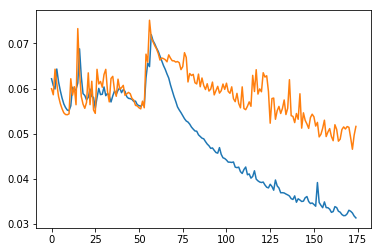

그------------------굴ᅳᆫ 클으 마ᅡ ᅡᅡ자ᅡᄂᄋᆫ 곤  도-아-ᄒ하-지-만ᆫ-----  잘는 게 인-저-로--  고-을을 조-아ᅡᄌ지 않----아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그굴ᅳᆫ 클으 마 ᅡ자ᄂᄋᆫ 곤 도아하지만 잘는 게 인저로 고을을 조아지 않아요.<eos>
그분은 훌륭한 학자인 건 분명하지만, 저는 개인적으로 그분을 좋아하지 않아요.<eos>-----------


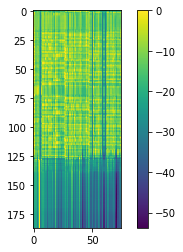

이-----------------심문ᆫᆫ 문닌 ᅵᅵ-이-서  구-느- 흐-는 그  간-니----  구-은 ᅳᆼ 묭뭉ᆼ이-이-어---ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이심문 문닌 ᅵ이서 구느 흐는 그 간니 구은 ᅳᆼ 묭뭉이이었다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


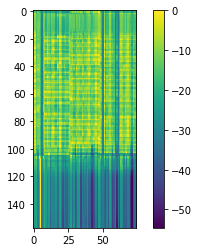

-------------------------------------------------------------------------------------------------------
09-01 13:11:43
Mean Train Loss: 0.0314076113040099
Mean Evaluation Loss: 0.04851868549741519
-------------------------------------------------------------------------------------------------------
09-01 13:12:02
Mean Train Loss: 0.03225009761246486
Mean Evaluation Loss: 0.05124492227400422
-------------------------------------------------------------------------------------------------------
09-01 13:12:22
Mean Train Loss: 0.031473657765463785
Mean Evaluation Loss: 0.048216006806672415
-------------------------------------------------------------------------------------------------------
09-01 13:12:42
Mean Train Loss: 0.03106408234208957
Mean Evaluation Loss: 0.04947564946770737
-------------------------------------------------------------------------------------------------------
09-01 13:13:02
Mean Train Loss: 0.03092307242817481
Mean Evaluation Loss: 0.05009380439058919
---------

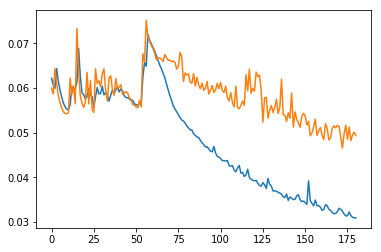

여-------------려-부른 이-모-세-서------   -----ᅳᅳ--------  -개---ᅡᅡ----   프--래- 드ᅳᆫ----  다-한한 정이  근-프ᄅ을 포-시ᅵ 수 있으-ᆸᆸ니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
여려부른 이모세서 ᅳ 개ᅡ 프래 든 다한한 정이 근프ᄅ을 포시 수 있읍니다.<eos>
여러분은 이곳에서 장미, 백합, 튤립 등 다양한 종류의 꽃들을 보실 수 있습니다.<eos>----------


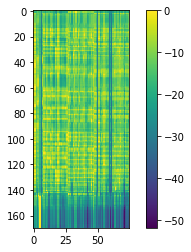

우-------------------는 상-만는  임ᄋ은 줌징이 있ᄋᆻ-애-서-----  숨은 칭ᅳᆫ ᅳᆫ-ᅳᅳ  궀움우  ᅵᅵᆻ사-으---ᆸ니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우는 상만는 임은 줌징이 있ᄋᆻ애서 숨은 칭ᅳᆫ ᅳᆫᅳ 궀움우 ᅵᆻ사읍니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


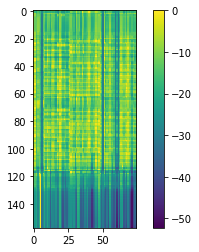

-------------------------------------------------------------------------------------------------------
09-01 13:13:42
Mean Train Loss: 0.03096816787497385
Mean Evaluation Loss: 0.05074511183666942
-------------------------------------------------------------------------------------------------------
09-01 13:14:02
Mean Train Loss: 0.030781861711948195
Mean Evaluation Loss: 0.05017102905082186
-------------------------------------------------------------------------------------------------------
09-01 13:14:23
Mean Train Loss: 0.030272977407825988
Mean Evaluation Loss: 0.04773761070640181
-------------------------------------------------------------------------------------------------------
09-01 13:14:42
Mean Train Loss: 0.029938474847345756
Mean Evaluation Loss: 0.04953599269769916
-------------------------------------------------------------------------------------------------------
09-01 13:15:02
Mean Train Loss: 0.02997197326327016
Mean Evaluation Loss: 0.049847595381158315
------

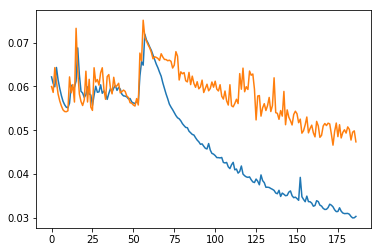

디-----------줌 두-이 개ᄉ수 들렁오-아-서----    우-이 ᄌ  저자ᅡ 공간이ᅵ 도조ᄀᄀᄃ하ᅡ는ᄉ사ᄉ시은 때  다-아--ᆻᆻ--어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
디줌 두이 개수 들렁오아서 우이 ᄌ 저자 공간이 도조ᄀᄃ하는사시은 때 다았어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


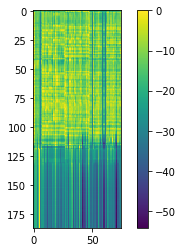

하---------------------ᄂᄆᆼᆼ은 엄치는 깅ᅵᆷ  여-징읐 근-지--ᅵ---------  진ᅳᆫ 강망항ᅳᅳ 무  ᅮ 믐-어----ᆻ--어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
하ᄂᄆᆼ은 엄치는 깅ᅵᆷ 여징읐 근지ᅵ 진ᅳᆫ 강망항ᅳ 무 ᅮ 믐었어요.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


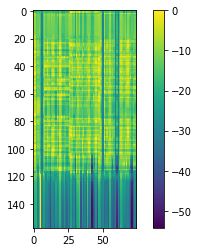

-------------------------------------------------------------------------------------------------------
09-01 13:15:43
Mean Train Loss: 0.030064419945736727
Mean Evaluation Loss: 0.05194616593487474
-------------------------------------------------------------------------------------------------------
09-01 13:16:03
Mean Train Loss: 0.029993692797009062
Mean Evaluation Loss: 0.05054748396980544
-------------------------------------------------------------------------------------------------------
09-01 13:16:22
Mean Train Loss: 0.0312277910491298
Mean Evaluation Loss: 0.04597468847607065
-------------------------------------------------------------------------------------------------------
09-01 13:16:42
Mean Train Loss: 0.029546698339451442
Mean Evaluation Loss: 0.04843946338192749
-------------------------------------------------------------------------------------------------------
09-01 13:17:02
Mean Train Loss: 0.029244758248396143
Mean Evaluation Loss: 0.04716535945551007
-------

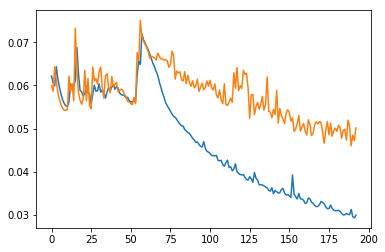

그--------------혀ᄂ는 자ᄉ시에  지는 게 이-영ᄋ애----   ᅧᅧ-의-ᄋ  부ᄅ를 축ᄀᄀ하는-대ᄂ는-  많우  가- 신르  없어-----ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그혀는 자시에 지는 게 이영애 ᅧ의ᄋ 부를 축ᄀ하는대는 많우 가 신르 없었다.<eos>
그녀는 자신의 재능을 이용해 명예와 부를 추구하는 데는 아무 관심이 없었다.<eos>------------------


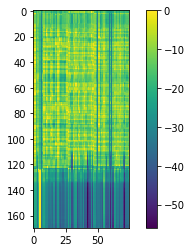

우--------------인 개-항인은ᆫ---  잉국인유먼 승 움묘-ᅧᆫᆫ  항ᄀ고-  강중-ᅡᆫ 망은 굥이 있스-ᆸᆸ-니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우인 개항인은 잉국인유먼 승 움묘ᅧᆫ 항고 강중ᅡᆫ 망은 굥이 있습니다.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


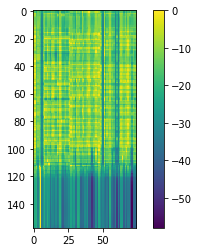

-------------------------------------------------------------------------------------------------------
09-01 13:17:42
Mean Train Loss: 0.03077649456911957
Mean Evaluation Loss: 0.04523042009032639
-------------------------------------------------------------------------------------------------------
09-01 13:18:03
Mean Train Loss: 0.02946815541838427
Mean Evaluation Loss: 0.04554162564418311
-------------------------------------------------------------------------------------------------------
09-01 13:18:23
Mean Train Loss: 0.03008790693797678
Mean Evaluation Loss: 0.045232023216763576
-------------------------------------------------------------------------------------------------------
09-01 13:18:43
Mean Train Loss: 0.029350768176295536
Mean Evaluation Loss: 0.05030850848109299
-------------------------------------------------------------------------------------------------------
09-01 13:19:03
Mean Train Loss: 0.02866209761116335
Mean Evaluation Loss: 0.045880573843378895
-------

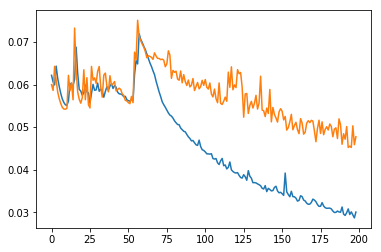

하--------------------국이 골등마  샌-느-시-에-는----   일시-신ᆫ길를 이-에  한버르ᅳᆯ 단는ᆫ 고--ᅩᄀ간 많-----아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
하국이 골등마 샌느시에는 일시신길를 이에 한버를 단는 고ᅩ간 많아요.<eos>
한국의 고등학생들 중에는 입시 준비를 위해 학원을 다니는 경우가 많아요.<eos>-----------------


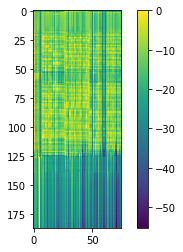

하--------------------아ᅡᆼ은 었짐ᅳᅳ 잉   영-지은 근--이---------------즈-  강망항으-오  ᅩ 므--ᅥ----ᆻ----어ᅥ요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
하앙은 었짐ᅳ 잉 영지은 근이즈 강망항으오 ᅩ 므ᅥᆻ어요.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


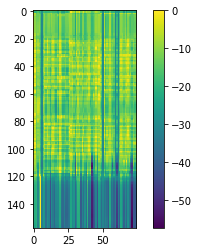

-------------------------------------------------------------------------------------------------------
09-01 13:19:44
Mean Train Loss: 0.0293754406928709
Mean Evaluation Loss: 0.04583395641330436
-------------------------------------------------------------------------------------------------------
09-01 13:20:03
Mean Train Loss: 0.02852954952777084
Mean Evaluation Loss: 0.04341154267137894
-------------------------------------------------------------------------------------------------------
09-01 13:20:23
Mean Train Loss: 0.02865471115739056
Mean Evaluation Loss: 0.046462323722130515
-------------------------------------------------------------------------------------------------------
09-01 13:20:43
Mean Train Loss: 0.028151609052856567
Mean Evaluation Loss: 0.04529808514567248
-------------------------------------------------------------------------------------------------------
09-01 13:21:03
Mean Train Loss: 0.028174496061469705
Mean Evaluation Loss: 0.048212886167817326
-------

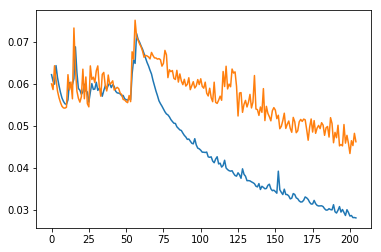

최-----------------건 복시ᄋ기 다ᄋᄋᆯ 태ᅢ혁건전일라ᅡᄀ고 알애 지-며-ᄉ서----- 구-시ᅵ으ᅳ라난 여ᅧᄌ자-ᅳᆯ이-   늘-고 이--ᆻᆻ--어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
최건 복시ᄋ기 다ᄋᆯ 태혁건전일라고 알애 지며서 구시으라난 여자ᅳᆯ이 늘고 있어요.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


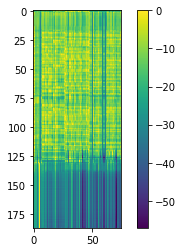

저--------------------능 이-국-시- 이ᄌᄌᆼᆫ ᄋᆼᆼ싰읐운인ᄀᄀ-ᄂ는-----  숭ᆼ자ᅡᆼ-믕은 ᄉ성있수ᅳᅳᆯ 증ᄋ옹ᄒᄒ---ᆸᆸ-니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저능 이국시 이ᄌᆼᆫ ᄋᆼ싰읐운인ᄀ는 숭장믕은 성있수ᅳᆯ 증옹ᄒᆸ니다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


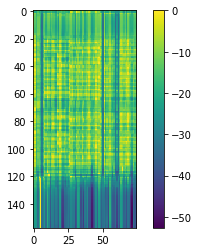

-------------------------------------------------------------------------------------------------------
09-01 13:21:43
Mean Train Loss: 0.02818868632639248
Mean Evaluation Loss: 0.05137945185574259
-------------------------------------------------------------------------------------------------------
09-01 13:22:03
Mean Train Loss: 0.028521575118461914
Mean Evaluation Loss: 0.04852565550519928
-------------------------------------------------------------------------------------------------------
09-01 13:22:23
Mean Train Loss: 0.02945201118191433
Mean Evaluation Loss: 0.047083378451023186
-------------------------------------------------------------------------------------------------------
09-01 13:22:43
Mean Train Loss: 0.028384284366468997
Mean Evaluation Loss: 0.04890870188860469
-------------------------------------------------------------------------------------------------------
09-01 13:23:03
Mean Train Loss: 0.028003513152282406
Mean Evaluation Loss: 0.04666935720745112
------

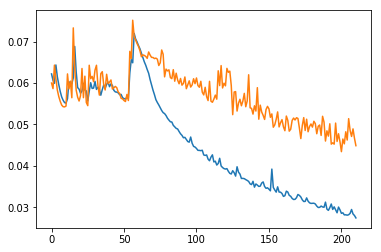

자----------------------ᆼ니-을 지-ᄋᄋ야 안-다ᄂ는  거-기 예-수ᄂ는 나--다-----   자--낸는 간-치------  ᄇ곡-평-석인  작ᆨ별 일-싱---------이다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
장니을 지야 안다는 거기 예수는 나다 자낸는 간치 ᄇ곡평석인 작별 일싱이다.<eos>
장례를 지내야 한다는 법이 있지는 않다. 장례는 단지 보편적인 작별 의식이다.<eos>-------------


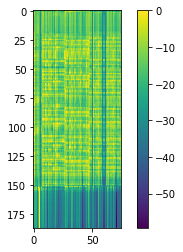

하------------------아ᅡᆼᅳᅳᆫ 엄짐ᅳᅳ 잉ᅵ  영징읐 끈-지-------------- 지-ᅳᆫ 강망항ᅳᆫ음 느 뭄-어---ᆻ---------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
하앙ᅳᆫ 엄짐ᅳ 잉ᅵ 영징읐 끈지 지ᅳᆫ 강망항ᅳᆫ음 느 뭄었어요.<eos>
딸아이는 어찌나 게임에 열중했던지 제가 다가가는 것도 몰랐어요.<eos>----------------


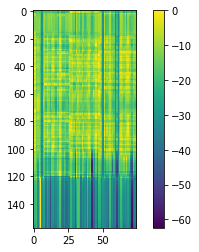

-------------------------------------------------------------------------------------------------------
09-01 13:23:44
Mean Train Loss: 0.02757126455231273
Mean Evaluation Loss: 0.047712406533363415
-------------------------------------------------------------------------------------------------------
09-01 13:24:04
Mean Train Loss: 0.02798622696188382
Mean Evaluation Loss: 0.044614424704600864
-------------------------------------------------------------------------------------------------------
09-01 13:24:23
Mean Train Loss: 0.027654174763314224
Mean Evaluation Loss: 0.046062592540441885
-------------------------------------------------------------------------------------------------------
09-01 13:24:43
Mean Train Loss: 0.02728950653149578
Mean Evaluation Loss: 0.04481430459305585
-------------------------------------------------------------------------------------------------------
09-01 13:25:03
Mean Train Loss: 0.027553111666764107
Mean Evaluation Loss: 0.04368645147398712
-----

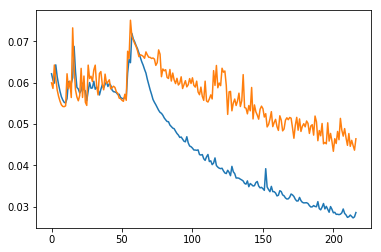

우-------------------리-느ᅳ--ᆫ------ 그-으ᄋ을 오-우-애 다-나-----  이으-을 정으-래ᅢ 도-어ᅥᄋ  ᄋᄋ이시ᅵ 거ᄅ라 ᄉᄉᆼ 각혀---ᆻᆻ------------어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우리는 그으을 오우애 다나 이으을 정으래 도어ᄋ 이시 거라 ᄉᆼ 각혔어요.<eos>
우리는 금요일 오후에 떠나 일요일 저녁에 돌아올 수 있을 거라 생각했어요.<eos>--------------------


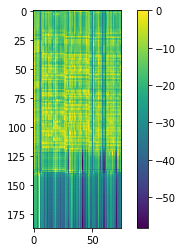

그 -----------------ᅳᆫ 망음움 시 꿈있승는  이-이-ᄒᆫᆻ 한ᄂᆫ-에-----------  않은 순ᄋᆫ 무-은 ᅵᅵᆼ능인닌 아---------------------야.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그 ᅳᆫ 망음움 시 꿈있승는 이이ᄒᆫᆻ 한ᄂᆫ에 않은 순ᄋᆫ 무은 ᅵᆼ능인닌 아야.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


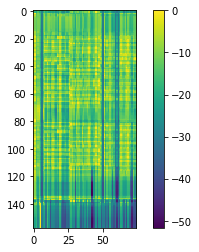

-------------------------------------------------------------------------------------------------------
09-01 13:25:43
Mean Train Loss: 0.029148878164510245
Mean Evaluation Loss: 0.04530431297121875
-------------------------------------------------------------------------------------------------------
09-01 13:26:03
Mean Train Loss: 0.028238468989764183
Mean Evaluation Loss: 0.044494969218013734
-------------------------------------------------------------------------------------------------------
09-01 13:26:23
Mean Train Loss: 0.027346199652855917
Mean Evaluation Loss: 0.04734960309842372
-------------------------------------------------------------------------------------------------------
09-01 13:26:42
Mean Train Loss: 0.027014625210778444
Mean Evaluation Loss: 0.044434874860781536
-------------------------------------------------------------------------------------------------------
09-01 13:27:03
Mean Train Loss: 0.027123061964406246
Mean Evaluation Loss: 0.04435963322264786
---

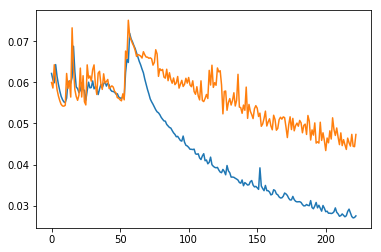

많------------------ᆼ는-격-고---  춘온 수-선-에-서ᅥ----  대-ᄋ경ᆼ이-가 시ᄋ이 공의 지-격은ᆫ-----  구-ᄉ성애-있서-  ᄌ준겨한 묘--수-----------------라.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
많ᆼ는격고 춘온 수선에서 대ᄋ경이가 시이 공의 지격은 구성애있서 준겨한 묘수라.<eos>
많은 경우 추리 소설에서 배경이나 주인공의 직업은 구성에 있어 중요한 요소다.<eos>---------------


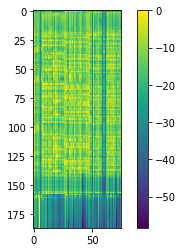

저--------------는 으-상앙이-----  앙ᆼ명ᆼ이  명증은 디-한ᅳᅳ 흔느-아--   마ᅡ믄  안 는----------------나요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 으상앙이 앙명이 명증은 디한ᅳ 흔느아 마믄 안 는나요.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


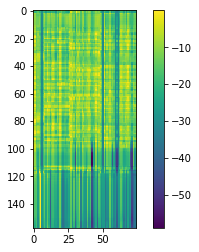

-------------------------------------------------------------------------------------------------------
09-01 13:27:43
Mean Train Loss: 0.027710998178710772
Mean Evaluation Loss: 0.04592896482070379
-------------------------------------------------------------------------------------------------------
09-01 13:28:03
Mean Train Loss: 0.027023225115647802
Mean Evaluation Loss: 0.043931341221967034
-------------------------------------------------------------------------------------------------------
09-01 13:28:23
Mean Train Loss: 0.0269157787737184
Mean Evaluation Loss: 0.040636846091818994
-------------------------------------------------------------------------------------------------------
09-01 13:28:44
Mean Train Loss: 0.0267161691320056
Mean Evaluation Loss: 0.04301487415508428
-------------------------------------------------------------------------------------------------------
09-01 13:29:04
Mean Train Loss: 0.02705228753570396
Mean Evaluation Loss: 0.04243495421577137
--------

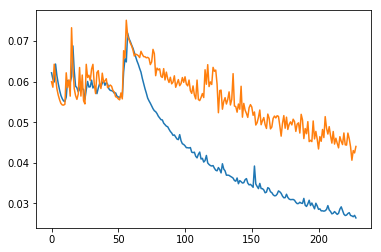

시------------------------사- 속복-그-ᄃ든-----  기-여르  상가라ᅡ지 안드로  결정애ᅦ스ᅮᅳᅮ 알를들릴 ᄃ-야-  이-거-히-----ᆸᆸᆸ------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
시사 속복그든 기여르 상가라지 안드로 결정애ᅦ스ᅮᅳᅮ 알를들릴 ᄃ야 이거힙니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


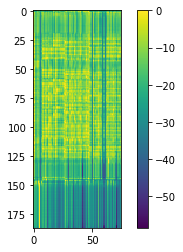

이---------------짐이-는ᆫ---   훙중ᄋ오-ᅡ  샀줌인  경ᆼ-이-마-   그-녕ᄋᆫᆫ 장잉 ᅭᆼ무 믄 만---------------아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이짐이는 훙중오ᅡ 샀줌인 경이마 그녕ᄋᆫ 장잉 ᅭᆼ무 믄 만아요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


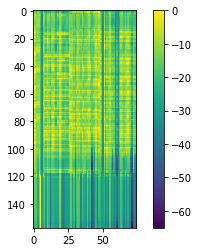

-------------------------------------------------------------------------------------------------------
09-01 13:29:44
Mean Train Loss: 0.026373877243158966
Mean Evaluation Loss: 0.04444743274319386
-------------------------------------------------------------------------------------------------------
09-01 13:30:03
Mean Train Loss: 0.027681008244397672
Mean Evaluation Loss: 0.04748925559001266
-------------------------------------------------------------------------------------------------------
09-01 13:30:23
Mean Train Loss: 0.031212463272148838
Mean Evaluation Loss: 0.0435351721697245
-------------------------------------------------------------------------------------------------------
09-01 13:30:43
Mean Train Loss: 0.02695692331629308
Mean Evaluation Loss: 0.04356271885404134
-------------------------------------------------------------------------------------------------------
09-01 13:31:03
Mean Train Loss: 0.0266063475367791
Mean Evaluation Loss: 0.045867380317156814
--------

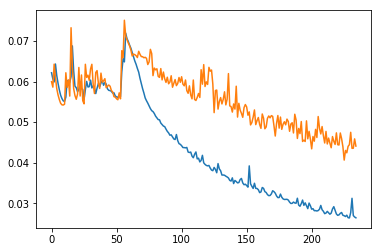

고----------------------ᆨ-제-읭ᄒ할으  뭉시  건어-은ᆫ-----  가--아--어--------   중-곡-어--,----   ᄋ어--어--------  -부-어---------  너ᅥ-시-ᄋᄋᄋᄋ--,,---  수-하ᄅ이-어--ᅵ---------ᅵ다.<eos>
곡제읭할으 뭉시 건어은 가아어 중곡어, 어어 부어 너시ᄋ, 수하ᄅ이어ᅵᅵ다.<eos>
국제연합의 공식 언어는 아랍어, 중국어, 영어, 불어, 러시아어, 스페인어이다.<eos>-----------------


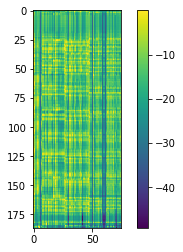

어------------니 난-즈-는ᆫ---  우-인흔ᄒ하있 선  가-장ᄋ인 기-이-는ᆫ-  으--ᅳᅩ 순순 ᅵᅵᆼ한ᄂ나-------------해요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
어니 난즈는 우인흔하있 선 가장인 기이는 으ᅳᅩ 순순 ᅵᆼ한나해요.<eos>
어린 왕자는 우리나라에서 가장 인기 있는 외국 소설 중 하나예요.<eos>-----------------


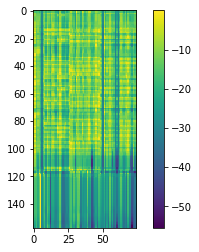

-------------------------------------------------------------------------------------------------------
09-01 13:31:43
Mean Train Loss: 0.027022975710001198
Mean Evaluation Loss: 0.043933821258049
-------------------------------------------------------------------------------------------------------
09-01 13:32:03
Mean Train Loss: 0.026347870955279653
Mean Evaluation Loss: 0.04216936286998355
-------------------------------------------------------------------------------------------------------
09-01 13:32:24
Mean Train Loss: 0.025788545647842085
Mean Evaluation Loss: 0.04570183844520348
-------------------------------------------------------------------------------------------------------
09-01 13:32:43
Mean Train Loss: 0.02617173495551086
Mean Evaluation Loss: 0.04426449873895089
-------------------------------------------------------------------------------------------------------
09-01 13:33:03
Mean Train Loss: 0.026098882199911775
Mean Evaluation Loss: 0.043390569750837264
-------

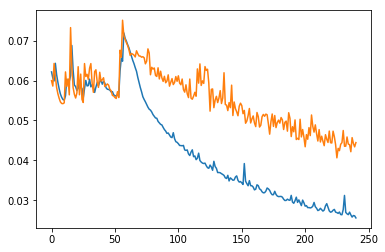

저-------------------는  나-지ᅵ 마-ᄋ이 갈-러-서----  새-려우 ᄉ사암ᆫ들이 ᄀ게  마ᅡ암을 며-는-데----   많은 시-한이 벌-여---------여요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저는 나지 마이 갈러서 새려우 사암ᆫ들이 게 마암을 며는데 많은 시한이 벌여여요.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


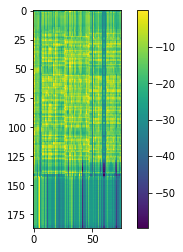

이------------ᆷ짐-이-는ᆫ---  훙중 헝 ᅡᆼ 사-중이-  겅-기--마-  응-녕-ᆫ  장잉요 으-은 마ᅡ---------------나요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
임짐이는 훙중 헝 ᅡᆼ 사중이 겅기마 응녕ᆫ 장잉요 으은 마나요.<eos>
요즘에는 표준어와 사투리의 경계가 분명하지 않은 경우가 많아요.<eos>-----------------


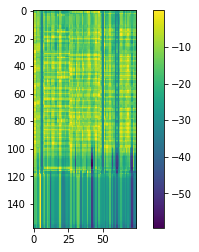

-------------------------------------------------------------------------------------------------------
09-01 13:33:44
Mean Train Loss: 0.025191229079759833
Mean Evaluation Loss: 0.04494755713402933
-------------------------------------------------------------------------------------------------------
09-01 13:34:03
Mean Train Loss: 0.025054872276259757
Mean Evaluation Loss: 0.043076769153615524
-------------------------------------------------------------------------------------------------------
09-01 13:34:23
Mean Train Loss: 0.02622128230723878
Mean Evaluation Loss: 0.044280779932617816
-------------------------------------------------------------------------------------------------------
09-01 13:34:43
Mean Train Loss: 0.025586061019571497
Mean Evaluation Loss: 0.044241781812226516
-------------------------------------------------------------------------------------------------------
09-01 13:35:03
Mean Train Loss: 0.02529563309535281
Mean Evaluation Loss: 0.04329019292848033
----

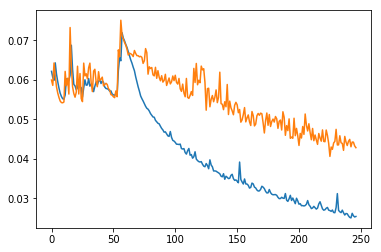

다---------------------시ᅵ의ᅴ 사ᄌ지을 언므- 도아ᅡ-고----  장지-아  갈-신-잘를ᆯ-  바-는 사-랑-가 공잉할 수 있스-ᆸᆸ----------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
다시의 사지을 언므 도아고 장지아 갈신잘를 바는 사랑가 공잉할 수 있습니다.<eos>
당신의 사진을 업로드하고 당신의 관심사를 다른 사람과 공유할 수 있습니다.<eos>----------------


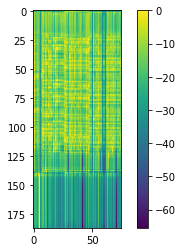

우--------------------ᅵ- 가ᅡ-ᅵᅵᆼ 있는 대-구-운으  사-군-니------  유-뭉믄 수ᄉᄋ이 교ᄒᆼᆼ운 두-으---ᆸ--------------니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우ᅵ 가ᅵᆼ 있는 대구운으 사군니 유뭉믄 수ᄉ이 교ᄒᆼ운 두읍니다.<eos>
우리 가게에 있는 대부분의 상품들이 유럽에서 수입해 온 것들입니다.<eos>------------


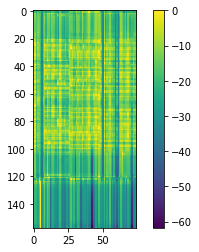

-------------------------------------------------------------------------------------------------------
09-01 13:35:43
Mean Train Loss: 0.044389994580923665
Mean Evaluation Loss: 0.060524263225299656
-------------------------------------------------------------------------------------------------------
09-01 13:36:04
Mean Train Loss: 0.05798483865130153
Mean Evaluation Loss: 0.04864051132593617
-------------------------------------------------------------------------------------------------------
09-01 13:36:24
Mean Train Loss: 0.05600063339789755
Mean Evaluation Loss: 0.054441076734607616
-------------------------------------------------------------------------------------------------------
09-01 13:36:43
Mean Train Loss: 0.05192513475836353
Mean Evaluation Loss: 0.05192601717676805
-------------------------------------------------------------------------------------------------------
09-01 13:37:03
Mean Train Loss: 0.048488692326262156
Mean Evaluation Loss: 0.04432343102621174
------

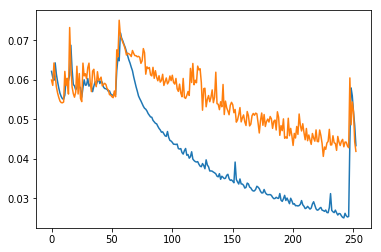

저--------------------ᅥ-는 나-시ᅵᅵ 많이 가-녀--서------  사-ᄒ헌사-안늘엘 이-에 마ᅡᅡ은 알는 느------  갆나  사ᅡᅡᆯ이 ᄋᄋᆯ 어-----아요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
저ᅥ는 나시 많이 가녀서 사헌사안늘엘 이에 마은 알는 느 갆나 살이 ᄋᆯ 어아요.<eos>
저는 낯을 많이 가려서 새로운 사람들에게 마음을 여는 데 많은 시간이 걸려요.<eos>----------------


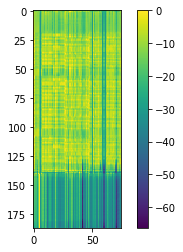

그-------------------------사ᅡ학으 ᄉᄉᆫ 장애-에-서------  장이 ᄋ인나-ᄋ에-ᄋ-ᄋᄋ--ᅩ---  상간  들 지ᅵ-거ᄋᄋᆯ이ᅵ 아 되------ᆫ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그사학으 ᄉᆫ 장애에서 장이 인나에ᄋ오 상간 들 지거ᄋᆯ이 아 된다.<eos>
그 사람은 술자리에서 자기 옛날이야기로 사람들을 지루하게 만든다.<eos>---------------


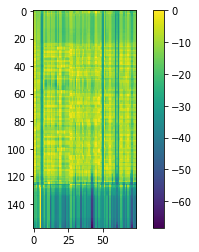

-------------------------------------------------------------------------------------------------------
09-01 13:37:44
Mean Train Loss: 0.04093777784851075
Mean Evaluation Loss: 0.03889577704663865
-------------------------------------------------------------------------------------------------------
09-01 13:38:04
Mean Train Loss: 0.038815589546057704
Mean Evaluation Loss: 0.037199078414505996
-------------------------------------------------------------------------------------------------------
09-01 13:38:24
Mean Train Loss: 0.03745789540412415
Mean Evaluation Loss: 0.03613502044458447
-------------------------------------------------------------------------------------------------------
09-01 13:38:44
Mean Train Loss: 0.036447585641069744
Mean Evaluation Loss: 0.0408142817232625
-------------------------------------------------------------------------------------------------------
09-01 13:39:04
Mean Train Loss: 0.03846925344684283
Mean Evaluation Loss: 0.03612248061935631
--------

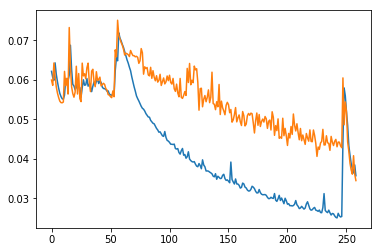

기-----------줌 굼이 이ᄉᄉ-들아-ᄋᆯ-며-서------- 오-이ᅵ으  저ᄌ자 궁간이 구ᅩ조 대ᅡᅡᅡᅳᆫ 사 시-ᅳᅳᆯ 디 다-하--ᆻᆻ--어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
기줌 굼이 이ᄉ들아ᄋᆯ며서 오이으 저자 궁간이 구ᅩ조 대ᅡᅳᆫ 사 시ᅳᆯ 디 다핬어요.<eos>
기증품이 계속 들어오면서 우리는 저장 공간이 부족하다는 사실을 깨달았어요.<eos>----------------


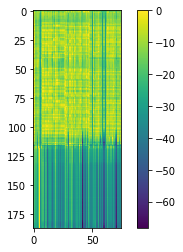

이-------------------ᄉᄉᆫ-으ᅳᅳ  오-애 디-에-서ᅥ 군매-다ᄅᄅᆯᆯ해 드-한-ᅡ-이---  구-가-잔 영운이ᅵ 되 어----ᆻ다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
이ᄉᆫ으 오애 디에서 군매다ᄅᆯ해 드한ᅡ이 구가잔 영운이 되 었다.<eos>
이승훈은 올림픽에서 금메달을 획득한 뒤 국가적 영웅이 되었다.<eos>------------


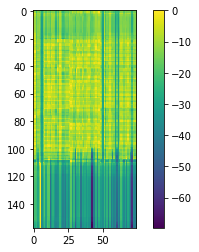

-------------------------------------------------------------------------------------------------------
09-01 13:39:44
Mean Train Loss: 0.034692220969699684
Mean Evaluation Loss: 0.03611906518738273
-------------------------------------------------------------------------------------------------------
09-01 13:40:03
Mean Train Loss: 0.035847076625292816
Mean Evaluation Loss: 0.03464084750027184
-------------------------------------------------------------------------------------------------------
09-01 13:40:23
Mean Train Loss: 0.0342443702647574
Mean Evaluation Loss: 0.04948184202705582
-------------------------------------------------------------------------------------------------------
09-01 13:40:43
Mean Train Loss: 0.04218967389241208
Mean Evaluation Loss: 0.03598429623138891
-------------------------------------------------------------------------------------------------------
09-01 13:41:03
Mean Train Loss: 0.035222240383202263
Mean Evaluation Loss: 0.034266921204093345
-------

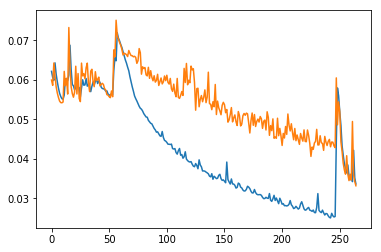

부----------------------ᅵ-느--ᅳ-------  고ᅳ느ᄋᄋ  온이 이 뎐라------  이ᅵᄅᄅᄋᆯ ᄌ저르-에   보ᅩᅥᅥᅥᅥ지ᅵ이ᅵᅵᅳᆯ걸하ᅡ슨하ᅡᄒ해---ᆻ---어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
부ᅵ느ᅳ 고ᅳ느ᄋ 온이 이 뎐라 이ᄅᄋᆯ 저르에 보ᅥ지이ᅳᆯ걸하슨하했어요.<eos>
우리는 금요일 오후에 떠나 일요일 저녁에 돌아올 수 있을 거라 생각했어요.<eos>--------------------


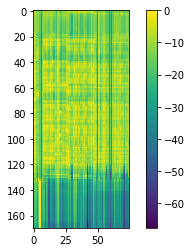

우-------------------르  장마ᅡᆫ는ᆫ 이ᅮᆼ은 존징에 시산 애ᄉ서----  치-은 치-애 든한 거 을로  이 산ᄒ하---ᆸ-니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우르 장만는 이ᅮᆼ은 존징에 시산 애서 치은 치애 든한 거 을로 이 산합니다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


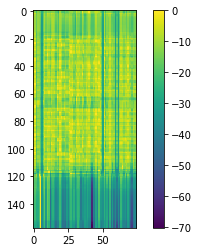

-------------------------------------------------------------------------------------------------------
09-01 13:41:44
Mean Train Loss: 0.033001041302344894
Mean Evaluation Loss: 0.032628952444089865
-------------------------------------------------------------------------------------------------------
09-01 13:42:04
Mean Train Loss: 0.03205138277461094
Mean Evaluation Loss: 0.03210330908146659
-------------------------------------------------------------------------------------------------------
09-01 13:42:24
Mean Train Loss: 0.031636850513677
Mean Evaluation Loss: 0.03168729903120501
-------------------------------------------------------------------------------------------------------
09-01 13:42:43
Mean Train Loss: 0.03140838002312255
Mean Evaluation Loss: 0.031103935153719
-------------------------------------------------------------------------------------------------------
09-01 13:43:03
Mean Train Loss: 0.030801158851582456
Mean Evaluation Loss: 0.030952863548148805
----------

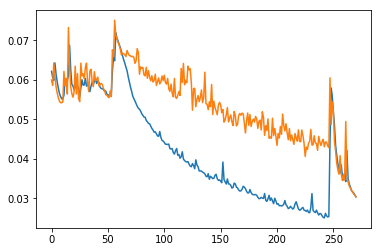

시------------------------- 사-ᄉ소 복을 때-------  개-ᅧᅧ른 성하ᅡᅡᅡᄌᄌ자ᅡ디ᅵ로 경ᆼ정ᄋᄋᆯ 숨마ᅡᄋᆯ를 들르-ᄃ대-어  이 가ᅡ-이--ᆸᆸᆸ-니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
시 사소 복을 때 개ᅧ른 성하자디로 경정ᄋᆯ 숨마ᄋᆯ를 들르대어 이 가입니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


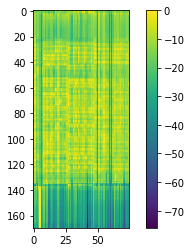

이---------------ᆫ나-에ᄂ는ᆫᆫ---  ᅡᅡᄉ신을ᄋ  손 발ᄀ강을-  ᄌ자-버-댈ᅵᅵ는 선ᄉᆫᆼ인드-이 있어--ᆻᆻ---어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
인나에는 ᅡ신을ᄋ 손 발강을 자버댈ᅵ는 선ᄉᆫᆼ인드이 있었어요.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


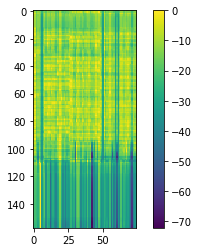

-------------------------------------------------------------------------------------------------------
09-01 13:43:43
Mean Train Loss: 0.03008009409756845
Mean Evaluation Loss: 0.030207946298777766
-------------------------------------------------------------------------------------------------------
09-01 13:44:03
Mean Train Loss: 0.03083245857298683
Mean Evaluation Loss: 0.03048204156857661
-------------------------------------------------------------------------------------------------------
09-01 13:44:23
Mean Train Loss: 0.02976800644114142
Mean Evaluation Loss: 0.030058926039078813
-------------------------------------------------------------------------------------------------------
09-01 13:44:43
Mean Train Loss: 0.02952644997198668
Mean Evaluation Loss: 0.02946533186805488
-------------------------------------------------------------------------------------------------------
09-01 13:45:03
Mean Train Loss: 0.029046408316907243
Mean Evaluation Loss: 0.029627632558091227
------

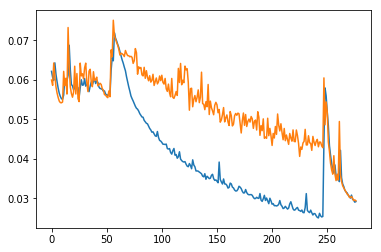

시------------------------성ᄉ속붐 ᅳᅳ-대ᅦ------ 기-겨-르  ᄉᆼ가ᅡ라ᅡᄌ 자ᅡ기ᅵ로  결정에ᅦ 수  ᅡᅡᅡᆯ려-들 리 대-여   이 가ᅡ-이--ᆸᆸᆸ--니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
시성속붐 ᅳ대ᅦ 기겨르 ᄉᆼ가라ᄌ 자기로 결정에 수 ᅡᆯ려들 리 대여 이 가입니다.<eos>
심사숙고 끝에 귀하를 선발하지 않기로 결정했음을 알려드리게 되어 유감입니다.<eos>--------------


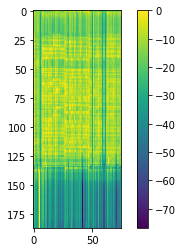

무---------------ᆫ수-ᄉ스를해  피 때 분에-  해ᅢ항그ᅳᆼ ᄋᆯ 도 우-으  고-ᄋ하-랠-고-   성글 갈ᄉ수-시-ᆻᆻ--어요.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
문수스를해 피 때 분에 해항긍 ᄋᆯ 도 우으 고ᄋ하랠고 성글 갈수싰어요.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


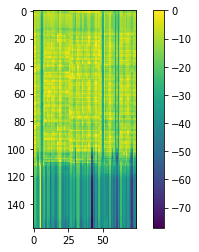

-------------------------------------------------------------------------------------------------------
09-01 13:45:44
Mean Train Loss: 0.028472271056904523
Mean Evaluation Loss: 0.029224227509336186
-------------------------------------------------------------------------------------------------------
09-01 13:46:04
Mean Train Loss: 0.03070035820621367
Mean Evaluation Loss: 0.030068525209925083
-------------------------------------------------------------------------------------------------------
09-01 13:46:23
Mean Train Loss: 0.029260372914102793
Mean Evaluation Loss: 0.02940974878838894
-------------------------------------------------------------------------------------------------------
09-01 13:46:44
Mean Train Loss: 0.02980481451996077
Mean Evaluation Loss: 0.03316722460076391
-------------------------------------------------------------------------------------------------------
09-01 13:47:04
Mean Train Loss: 0.029615750140845016
Mean Evaluation Loss: 0.029654240765234645
----

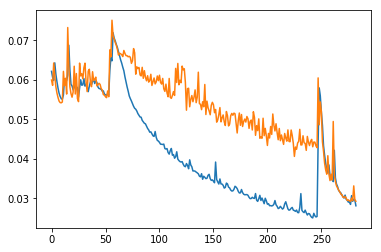

우-------------리ᄂ는  청국을 구-진-년에--  해-사ᄅ를 살이  한디-에--   마ᅡᅡ는 애고ᅩ긴ᄃ드으  지ᄋᄋᆫ외 ᄋ었스--ᆸᆸᆸ-----니다.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
우리는 청국을 구진년에 해사를 살이 한디에 마는 애고긴드으 지ᄋᆫ외 었습니다.<eos>
우리는 십구백구십 년에 회사를 설립한 이래 많은 외국인들을 지원해 왔습니다.<eos>------------


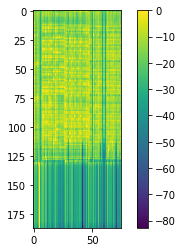

그 ----------------ᄉᄉ-람ᄋᄆᆷ그  싶붕이  산난 이-기-한ᆻ다ᄂ는-게----------  나-릉 수ᄂ는 명한인 냉이-니 안-------------------이야.<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>
그 ᄉ람ᄋᄆᆷ그 싶붕이 산난 이기한ᆻ다는게 나릉 수는 명한인 냉이니 안이야.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


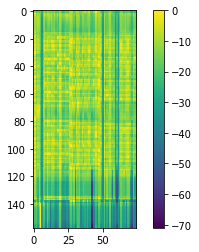

-------------------------------------------------------------------------------------------------------
09-01 13:47:44
Mean Train Loss: 0.027898248551191836
Mean Evaluation Loss: 0.029370723880528575
-------------------------------------------------------------------------------------------------------
09-01 13:48:04
Mean Train Loss: 0.028186656712468967
Mean Evaluation Loss: 0.029060783236696405
-------------------------------------------------------------------------------------------------------
09-01 13:48:23
Mean Train Loss: 0.02782360160776959
Mean Evaluation Loss: 0.02905832673210778
-------------------------------------------------------------------------------------------------------
09-01 13:48:43
Mean Train Loss: 0.028126794734048815
Mean Evaluation Loss: 0.030178187169714526
-------------------------------------------------------------------------------------------------------
09-01 13:49:03
Mean Train Loss: 0.02781824665848703
Mean Evaluation Loss: 0.029507601151913726
---

KeyboardInterrupt: ignored

In [28]:
EPOCH = 3 * 60 * 4
    
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_2')
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_test.initialize_batch()
    loss_list_eval = list()
    
    while preloader_test.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_test.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/CTC_eval_2_')
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_2_.npy', loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_2_.npy', loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        _, index = pred_tensor[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")